# Анализ поведения пользователей мобильного приложения

<div style="border: solid seagreen 1px; padding: 10px">  

Мы аналитики мобильного приложения "Ненужные вещи", в котором пользователи продают свои ненужные вещи, размещая их на доске объявлений. Менеджеры продукта стремятся повысить число сделок через приложение и для этого хотят лучше узнать пользователей: кто чаще возвращается в приложение, кто чаще осуществляет целевое действие - просмотр контактов в объявлении.

Наша **задача**:  
1) исследовать поведение пользователей по основным метрикам (retention rate, конверсия, длительность сессии, частота совершения событий),  
2) сегментировать пользователей, выделив наиболее активную (целевую) и смежные аудитории,  
3) проверить гипотезы о разнице конверсии в целевое действие по разным категориям пользователей.
    
Источник информации для исследования - логи событий, совершенных в мобильном приложении. Датасет содержит данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.
    
В рамках поставленных задач будут выполнены следующие шаги:
- [обзор данных](#overview),
- [предобработка данных](#data_processing),
- [исследовательский анализ данных](#EDA),
- [сегментирование пользователей](#segmentation),
- [проверка статистических гипотез](#AB_test),
- [выводы](#summary).

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import datetime as dt
from statsmodels.stats.proportion import proportions_ztest

# для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go

# уберем интерактивность графиков plotly для отображения на github
import plotly.io as pio
pio.renderers.default = "svg"

# настраиваем отображение всех колонок датафрейма при выводе данных
pd.options.display.max_columns = None

# отключаем предупреждения
import warnings 
warnings.filterwarnings('ignore')

# зададим общую палитру для графиков
colours = ['#74AB5C','#B3D7A3','#C7C0DF','#9C8CD4','#5A5387','#FFE47B','#F4CCCC','#E73333','#796BC9']
sns.set_palette(palette=colours)

<a id='overview'></a>
## Загрузка и обзор данных

In [2]:
# загружаем данные

try:
    events = pd.read_csv('/datasets/mobile_dataset.csv')
    sourсes = pd.read_csv('/datasets/mobile_soures.csv')
except:
    events = pd.read_csv(
        '/Users/mrmrzpn/Desktop/Yandex Praktikum/2. Проекты/10. Финальный проект/1. Проект 1/mobile_dataset.csv')
    sourсes = pd.read_csv(
        '/Users/mrmrzpn/Desktop/Yandex Praktikum/2. Проекты/10. Финальный проект/1. Проект 1/mobile_sourсes.csv')

In [3]:
# смотрим информацию о датафреймах

for data in [events, sourсes]:
    name = [key for key in globals() if globals()[key] is data]
    print('Датасет', name[0], '\n')
    data.info()
    display(data.head())
    print('--'*50)

Датасет events 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

----------------------------------------------------------------------------------------------------
Датасет sourсes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

----------------------------------------------------------------------------------------------------


**Описание данных:**  

Датасет **mobile_dataset.csv (events)** содержит колонки:  
`event.time` — время совершения  
`event.name` — название события  
`user.id` — идентификатор пользователя

Датасет **mobile_sources.csv (sourсes)** содержит колонки:  
`userId` — идентификатор пользователя  
`source` — источник, с которого пользователь установил приложение  

Расшифровки событий:  
*advert_open* — открытие карточки объявления  
*photos_show* — просмотр фотографий в объявлении  
*tips_show* — пользователь увидел рекомендованные объявления  
*tips_click* — пользователь кликнул по рекомендованному объявлению  
*contacts_show* и *show_contacts* — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления  
*contacts_call* — пользователь позвонил по номеру телефона на карточке объявления  
*map* — пользователь открыл карту размещенных объявлений  
*search_1* — *search_7* — разные события, связанные с поиском по сайту  
*favorites_add* — добавление объявления в избранное

**Наблюдения:**
- Информация представлена по 4293 пользователям и 74197 событиям;
- Пропусков в данных нет;
- Тип данных в столбце `event.time` датафрейма **events** некорректный, его нужно исправить;
- Столбцы переименуем для удобства анализа.

<a id='data_processing'></a>
## Предобработка данных

### Проверка на наличие дубликатов

**1. Полные дубликаты**

In [4]:
# считаем число полных дубликатов

print('Число полных дубликатов в датасете events -', events.duplicated().sum())
print('Число полных дубликатов в датасете sourсes -', sourсes.duplicated().sum())

Число полных дубликатов в датасете events - 0
Число полных дубликатов в датасете sourсes - 0


Явные дубликаты не найдены.

**2. Неявные дубликаты**

In [5]:
# выведем список уникальных названий события

sorted(events['event.name'].unique())

['advert_open',
 'contacts_call',
 'contacts_show',
 'favorites_add',
 'map',
 'photos_show',
 'search_1',
 'search_2',
 'search_3',
 'search_4',
 'search_5',
 'search_6',
 'search_7',
 'show_contacts',
 'tips_click',
 'tips_show']

События *contacts_show* и *show_contacts* - одно и то же, поэтому назовем их одинаково. Также объединим все события-поиски в одну группу *search*.

In [6]:
# добавим столбец с измененными названиями событий

events['event_name_new'] = events['event.name']
events['event_name_new'] = events['event_name_new'].str.replace('show_contacts', 'contacts_show')
events.loc[events['event_name_new'].str.contains('search'), 'event_name_new'] = 'search'

### Переименование столбцов

In [7]:
events.columns = ['event_time', 'event_name', 'user_id', 'event_name_new']

In [8]:
sourсes.columns = ['user_id', 'source']

### Изменение типа данных

In [9]:
# меняем тип данных в столбце со временем события

events['event_time'] = events['event_time'].astype('datetime64[s]')

----

**Общий вывод:** Поскольку данные заполняются автоматически, в возможных ошибках исключен человеческий фактор и отсутствуют проблемы с неполнотой информации. Однако отметим некоторые недостатки:  
- Столбцы в связанных таблицах называются-по разному ("user.id" и "userId"), что немного усложняет работу с ними: сопоставление/объединение данных требует предварительного переименования столбцов;
- В данных есть неявные дубликаты в названиях событий, которые, вероятно, появились в результате изменения подхода к обозначению типов действий;
- Непонятна суть разделения событий-поисков на группы 1-7 для данного типа выгрузки. Если такая аналитика важна, стоит добавлять дополнительный столбец с пояснением или указывать смысл разбивки в описании данных;
- В выгрузке отсутствует информация о сессиях: id сессии, её продолжительность, время начала и окончания.

<a id='EDA'></a>
## Исследовательский анализ данных

### Период наблюдений

Посмотрим, за какой период представлены данные:

In [10]:
# определим минимальную и максимальную даты событий

print('Начало периода наблюдений - {}, конец - {}'
      .format(events['event_time'].min(), events['event_time'].max())
     )

print('Полных дней - {}'
      .format((events['event_time'].max() - events['event_time'].min()).days)
     )

Начало периода наблюдений - 2019-10-07 00:00:00, конец - 2019-11-03 23:58:12
Полных дней - 27


Данные представлены за 4 недели, полных 27 дней.

### Число событий по времени суток

In [11]:
# округлим время до 1 часа в меньшую сторону
events['date_hour'] = events['event_time'].dt.floor('1H')

# сохраним данные о часе посещения в отдельную колонку
events['hour'] = events['date_hour'].dt.time.astype('str').apply(lambda x: x[:5])

Построим почасовой график событий:

In [12]:
# группируем данные по датам и часам
events_frequency = (events
                    .groupby('date_hour')
                    .agg({'event_name':'count'})
                    .sort_values(by='date_hour')
                    .rename(columns={'event_name':'events_number'})
                    .reset_index()
                   )
# строим график
fig1 = px.bar(events_frequency,
               x='date_hour',
               y='events_number'
             )
fig1.update_layout(title={'text':'Частота событий по дням и часам',
                          'y':.95,
                          'x':.05,
                          'font.size':14},
                   plot_bgcolor='white',
                   height=300, width=950,
                   xaxis_title='',
                   yaxis_title='Количество событий, ед.',
                   font_size=10
                  )
fig1.update_xaxes(tickformat='%d-%b %H:%M', tickangle=45)
fig1.update_traces(marker_color=colours[3])
pass

Построим график распределения всех событий и уникальных пользователей по времени суток:

In [13]:
# группируем данные по часам
events_hourly = (events
                 .groupby('hour')
                 .agg({'event_name':'count', 'user_id':'nunique'})
                 .rename(columns={'event_name':'events_number', 'user_id':'unique_users'})
                 .reset_index()
                )
# строим график с числом уникальных пользователей на вторичной оси y
fig2 = make_subplots(specs=[[{"secondary_y": True}]])

fig2.add_trace(go.Bar(x=events_hourly['hour'],
                      y=events_hourly['events_number'],
                      marker_color=colours[1],
                      name='Число событий',
                      width=.5, opacity=.8)
              )
fig2.add_trace(go.Scatter(x=events_hourly['hour'],
                          y=events_hourly['unique_users'],
                          mode='lines',
                          name='Число уникальных пользователей',
                          marker_color=colours[3]),
               secondary_y=True)

fig2.update_yaxes(title_text='Количество событий, ед.', secondary_y=False,
                  tickvals=np.arange(0, 6000, 1000))
fig2.update_yaxes(title_text='Число уникальных<br>пользователей', secondary_y=True,
                  tickvals=np.arange(0, 800, 100))

fig2.update_layout(height=320, width=600, plot_bgcolor='white', font_size=10,
                   title={'text':'Распределение числа событий и уникальных пользователей<br>по времени суток',
                          'y':.85,
                          'x':.09,
                          'font.size':14},
                   legend=dict(orientation='h', y=-.3, x=0))
fig2.update_xaxes(tickangle=45)
pass

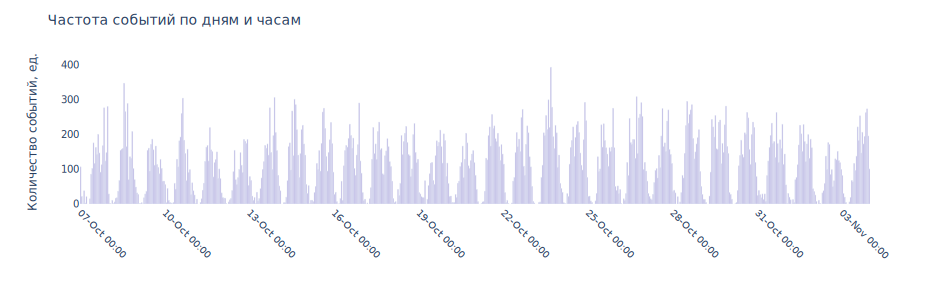

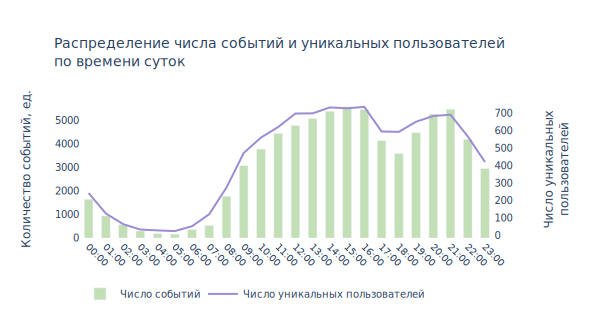

In [14]:
# выводим графики

fig1.show()
fig2.show()

**Наблюдения:** Приложением пользуются практически каждый час. В ночные часы количество действий в приложении ожидаемо на низком уровне. Число событий растет с началом рабочего дня и немного снижается после окончания рабочего дня (17-18 часов), когда пользователи находятся в пути домой. Пик пользовательской активности за день приходится на время обеда (14-16 часов) и вечер (20-21 час). Число событий практически прямо зависит от числа активных пользователей.

### Число событий по дням недели

In [15]:
# добавим в датасет visits колонку с датой события без времени

events['dt'] = events['event_time'].dt.date

In [16]:
# добавим в датасет visits колонку с днем недели

events['weekday'] = events['event_time'].dt.weekday

Построим графики числа событий по датам и дням недели:

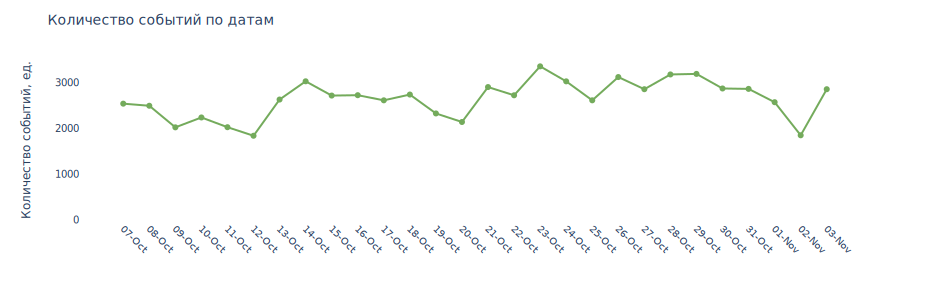

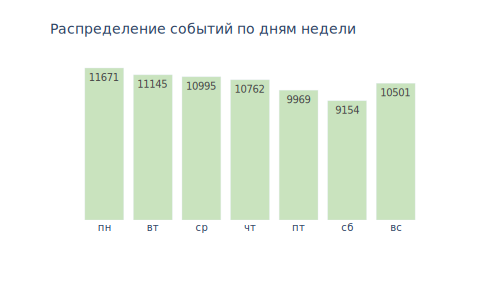

In [17]:
# группируем данные по датам
events_daily = (events
                .groupby(['dt','weekday'])
                .agg({'event_name':'count'})
                .sort_values(by='dt')
                .rename(columns={'event_name':'events_number'})
                .reset_index()
               )
events_daily['weekday'] = events_daily['weekday'].replace(
    {0:'пн', 1:'вт', 2:'ср', 3:'чт', 4:'пт', 5:'сб', 6:'вс'})

# группируем данные по дням недели
events_weekday = (events
                  .groupby('weekday')
                  .agg({'event_name':'count'})
                  .sort_values(by='weekday')
                  .rename(columns={'event_name':'events_number'})
                  .reset_index()
                 )
# рисуем график по датам
fig1 = px.line(events_daily,
               x='dt',
               y='events_number',
               markers=True,
               hover_data=['dt', 'weekday', 'events_number'],
               range_y=[0, 3500],
               color_discrete_sequence=[colours][0]
              )
fig1.update_layout(title = {'text':'Количество событий по датам',
                            'y':.95,
                            'x':.05,
                            'font.size':14,
                           },
                   plot_bgcolor='white',
                   height=300, width=950,
                   xaxis_title='',
                   yaxis_title='Количество событий, ед.',
                   font_size=10
                  )
fig1.update_xaxes(tickvals=list(events_daily['dt']), tickangle=45, tickformat='%d-%b')

# рисуем график по дням недели
fig2 = px.bar(events_weekday,
              x='weekday',
              y='events_number',
              text='events_number',
              opacity=.7
             )
fig2.update_layout(title = {'text':'Распределение событий по дням недели',
                            'y':.92,
                            'x':.1,
                            'font.size':14,
                           },
                   plot_bgcolor='white',
                   height=300, width=500,
                   xaxis_title='',
                   yaxis_title='',
                   font_size=10,
                   hovermode=False
                  )
fig2.update_yaxes(visible=False)
fig2.update_xaxes(tickvals=list(events_weekday['weekday']), ticktext=['пн','вт','ср','чт','пт','сб','вс'])
fig2.update_traces(textposition='inside', marker_color=colours[1])

# выводим графики
fig1.show()
fig2.show()

In [18]:
# рассчитаем медианное количество событий за день

print('Медианное количество событий за день в анализируемом периоде - {:.0f}'
      .format(events_daily['events_number'].median())
     )

Медианное количество событий за день в анализируемом периоде - 2725


**Наблюдения:** Количество событий за день в рассматриваемом периоде варьируется от 1843 до 3361, медиана - 2725. Судя по ежедневной динамике, число событий в целом не зависит от дня недели, однако по пятницам и субботам наблюдается снижение пользовательской активности: что логично, поскольку это время люди в основном используют для активного отдыха и встреч с близкими.

### Число событий по типам

In [19]:
# посмотрим на количество событий в разрезе типов
events_by_type = (events
                  .groupby('event_name_new')
                  .agg({'user_id':'count'})
                  .sort_values(by='user_id', ascending=False)
                  .rename(columns={'user_id':'events_number'})
                  .reset_index()
                )

# посмотрим на частоту событий в виде доли от общего количества событий 
events_by_type['share'] = events_by_type['events_number'].div(events.shape[0])

# покажем долю в %
events_by_type.style.format({'share':'{:.2%}'})

Построим графики распределения событий по типам:

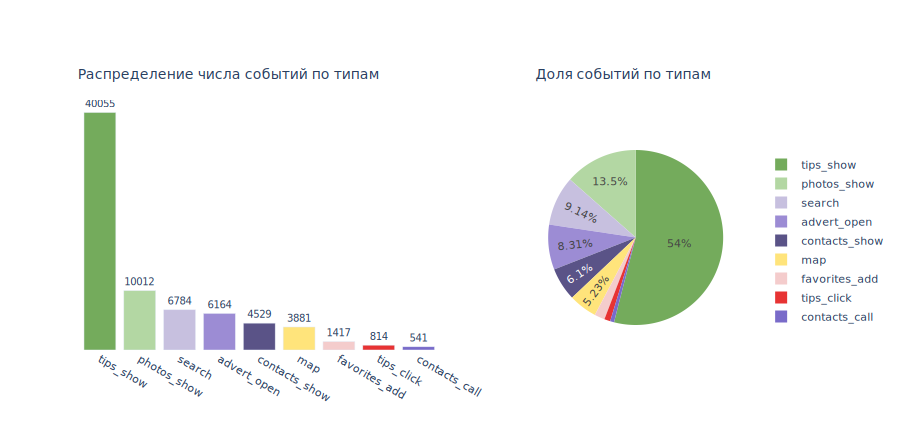

In [20]:
# создаем общую область построения двух графиков рядом друг с другом
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'xy'}, {'type':'domain'}]],
                    horizontal_spacing=0
                   )
# рисуем первый график
fig.add_trace(go.Bar(x=events_by_type['event_name_new'],
                     y=events_by_type['events_number'],
                     text=events_by_type['events_number'],
                     textposition='outside',
                     marker_color=colours,
                     hoverinfo='skip',
                     showlegend=False
                    ),
              1, 1)
# рисуем второй график
fig.add_trace(go.Pie(values=events_by_type['events_number'],
                     labels=events_by_type['event_name_new'],
                     textposition='inside',
                     textinfo='percent',
                     marker_colors=colours,
                     hoverinfo='label+percent'
                    ),
              1, 2)
# настраиваем формат
fig.update_yaxes(visible=False)
fig.update_layout(height=430, width=900, plot_bgcolor='white', font_size=11,
                  uniformtext_minsize=10, uniformtext_mode='hide',
                  legend=dict(x=.95, y=.8)
                 )
fig.data[1].domain = {'x':[.55, 1], 'y': [.1, .8]}

# добавляем заголовки
fig.add_annotation(text="Распределение числа событий по типам",
                   font_size=14,
                   xref="paper", yref="paper",
                   x=0, y=1.15, showarrow=False)
fig.add_annotation(text="Доля событий по типам",
                   font_size=14,
                   xref="paper", yref="paper",
                   x=.88, y=1.15, showarrow=False)

fig.show()

**Наблюдения:** Наиболее частое событие - просмотр рекомендованных объявлений (tips_show), на него приходится более половины всех событий в логе. Далее идут просмотр фотографий (photos_show), поиск по объявлениям (search) и открытие страницы с объявлением (advert_open). Целевое действие - просмотр контактов (contacts_show) - составляет 6.1% событий в логе.

### Число пользователей по типам событий

In [21]:
# посмотрим на число уникальных пользователей в разрезе типов событий
users_by_event = (events
                  .groupby('event_name_new')
                  .agg({'user_id':'nunique'})
                  .sort_values(by='user_id', ascending=False)
                  .rename(columns={'user_id':'unique_users'})
                  .reset_index()
                 )

# посмотрим на долю уникальных пользователей от общего числа в разрезе типов событий
users_by_event['share'] = users_by_event['unique_users'].div(events['user_id'].nunique())

# покажем долю в %
users_by_event.style.format({'share':'{:.2%}'})

**Наблюдения:** Пользователи в основном начинают взаимодействие с приложением со страницы рекомендованных объявлений (*tips_show*) или поиска объявлений (*search*). До целевого действия - просмотра контактов (*contacts_show*) - за рассматриваемый период дошло лишь 22.85% пользователей.  

Четкой продуктовой воронки у приложения нет, поведение пользователей хаотично. Просмотр контактов и фотографий в объявлении возможен без открытия карточки объявления.

### Число событий на одного пользователя

In [22]:
# рассчитаем число событий для каждого пользователя
events_by_user = (events
                  .groupby('user_id', as_index=False)
                  .agg({'event_name':'count'})
                  .rename(columns={'event_name':'events_number'})
                 )

# рассчитаем среднее число событий на одного пользователя
print('Среднее число событий на одного пользователя - {:.2f}'
      .format(events_by_user['events_number'].mean())
     )

# рассчитаем медианное число событий на одного пользователя
print('Медианное число событий на одного пользователя - {:.2f}'
      .format(events_by_user['events_number'].median())
     )

Среднее число событий на одного пользователя - 17.28
Медианное число событий на одного пользователя - 9.00


**Наблюдения:** Среднее число событий на одного пользователя выше медианного на 8 единиц, что может быть результатом влияния аномалий - малого числа очень активных пользователей, которые смещают среднее в большую сторону.  

Посмотрим на распределение числа событий одного пользователя.

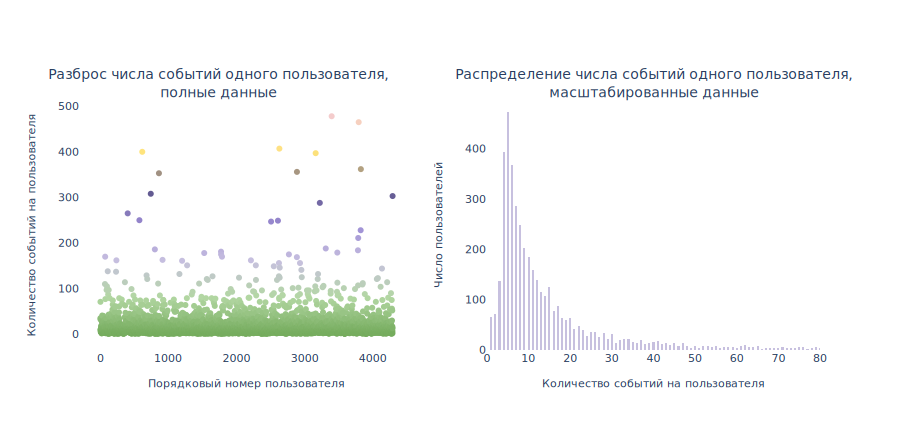

In [23]:
# построим графики разброса и распределения количества событий на одного пользователя

# порядковые номера уникальных пользователей используем в качестве координат оси Х для scatter plot
# таким образом покажем число событий каждого пользователя
x_values = pd.Series(range(0,len(events_by_user)))

# создаем общую область построения двух графиков рядом друг с другом
fig = make_subplots(rows=1, cols=2, horizontal_spacing=.1)

# рисуем первый график
fig.add_trace(go.Scatter(x=x_values,
                         y=events_by_user['events_number'],
                         mode='markers',
                         marker=dict(size=6, color=events_by_user['events_number'],
                                     colorscale=colours[0:7]),
                         hoverinfo='y',
                         showlegend=False
                        ),
              1, 1)
# рисуем второй график
fig.add_trace(go.Histogram(x=events_by_user['events_number'],
                           marker_color=colours[2],
                           hoverinfo='x+y',
                           showlegend=False,
                           nbinsx=1000
                          ),
              1, 2)
# настраиваем формат
fig.update_layout(height=430, width=900, plot_bgcolor='white', font_size=11)
fig.update_xaxes(row=1, col=1, title='Порядковый номер пользователя', title_font_size=11)
fig.update_yaxes(row=1, col=1, title='Количество событий на пользователя', title_font_size=11)
fig.update_xaxes(row=1, col=2, title='Количество событий на пользователя', title_font_size=11,
                 tickvals=np.arange(0, 90, 10), range=[0, 80])
fig.update_yaxes(row=1, col=2, title='Число пользователей', title_font_size=11)

# добавляем заголовки
fig.add_annotation(text="Разброс числа событий одного пользователя,<br>полные данные",
                   font_size=14,
                   xref="paper", yref="paper",
                   x=-.04, y=1.15, showarrow=False)
fig.add_annotation(text="Распределение числа событий одного пользователя,<br>масштабированные данные",
                   font_size=14,
                   xref="paper", yref="paper",
                   x=1.04, y=1.15, showarrow=False)

fig.show()

**Наблюдения:** В данных действительно наблюдаются аномально активные пользователи, которые искажают средний показатель числа событий на человека: на первом графике видно, что количество событий некоторых пользователей достигает сотен единиц. Из второго графика видно, что основная масса пользователей осуществляет от 3 до 15 действий в приложении, наиболее часто - 5 действий.

### Распределение пользователей по источникам

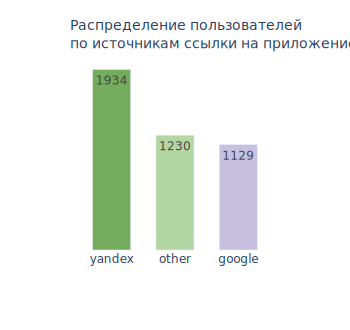

In [24]:
# посмотрим на распределение пользователей по источникам

fig = px.bar((sourсes.groupby('source', as_index=False)
              .agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)
             ),
             x='source',
             y='user_id',
             text='user_id'
            )
fig.update_layout(title = {'text':'Распределение пользователей<br>по источникам ссылки на приложение',
                           'x':.2,
                           'font.size':14,
                          },
                  xaxis_title='',
                  plot_bgcolor='white',
                  height=330, width=350,
                  showlegend=False,
                  hovermode=False
                 )
fig.update_yaxes(visible=False)
fig.update_traces(textposition='inside', marker_color=colours[:3], width=.6)

fig.show()

**Наблюдения:** Пользователи в основном находят приложение через поисковик Yandex. Через Google приложение ищут реже, чем через другие источники (включая поиск напрямую в магазине приложений).

In [25]:
# добавим в основной датасет информацию об источниках ссылки на приложение

events = events.merge(sourсes, on='user_id', how='left')

### Профили пользователей

Для анализа продолжительности перерывов между сессиями, расчета retention rate и конверсии сформируем датасет, содержащий профили пользователей: id, источник ссылки на приложение, сегмент пользователя, группа А/В теста, дата начала использования приложения, признак совершения целевого действия за рассматриваемый период.  

На сегменты и группы А/В теста пользователей разделим далее, а пока создадим пустые столбцы:

In [26]:
events['segment'] = 0
events['ab_group'] = 0

In [27]:
# объявим функцию для создания пользовательских профилей

def get_profiles(events):

    # для каждого пользователя указываем параметры первого входа в приложение
    profiles = (events
                .groupby('user_id')
                .agg({'source': 'first',
                      'segment': 'first',
                      'ab_group': 'first',
                      'event_time': 'first',
                      'dt': 'first'
                     })
                .rename(columns={'event_time': 'first_ts'})
                .reset_index()
               )

    # определяем месяц первого посещения
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак совершения целевого действия
    profiles['contacts_viewed'] = (profiles['user_id']
                                   .isin(events.query('event_name_new == "contacts_show"')['user_id'].unique())
                                  )
    return profiles

In [28]:
# сохраним профили пользователей
profiles = get_profiles(events)

# посмотрим на первые 5 строк таблицы
profiles.head()

user_id  source  segment  ab_group  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other        0         0   
1  00157779-810c-4498-9e05-a1e9e3cedf93  yandex        0         0   
2  00463033-5717-4bf1-91b4-09183923b9df  yandex        0         0   
3  004690c3-5a84-4bb7-a8af-e0c8f8fca64e  google        0         0   
4  00551e79-152e-4441-9cf7-565d7eb04090  yandex        0         0   

             first_ts          dt      month  contacts_viewed  
0 2019-10-07 13:39:45  2019-10-07 2019-10-01            False  
1 2019-10-19 21:34:33  2019-10-19 2019-10-01             True  
2 2019-11-01 13:54:35  2019-11-01 2019-11-01            False  
3 2019-10-18 22:14:05  2019-10-18 2019-10-01            False  
4 2019-10-25 16:44:41  2019-10-25 2019-10-01             True

### Время, проведенное в приложении

#### Разделение событий на сессии

In [29]:
# отсортируем датасет по id пользователя и времени события
events = events.sort_values(by=['user_id', 'event_time']).reset_index(drop=True)

# рассчитаем временную разницу между действиями в разрезе пользователей
events['time_diff'] = events.groupby('user_id')['event_time'].diff()

# переведем разницу в минуты
events['diff_minutes'] = events['time_diff'].dt.total_seconds().div(60)

Сессию будем считать завершенной, если пользователь не совершал действия в течение какого-то промежутка времени. Поскольку пользователи активны в основном в рабочие часы, предположим, что время сессии не должно превышать 1 час, и значит, временная разница между событиями должна быть меньше 60 минут. Чтобы определить конкретный порог времени между событиями, который будем считать окончанием сессии, посмотрим на распределение временной разницы между действиями пользователя.

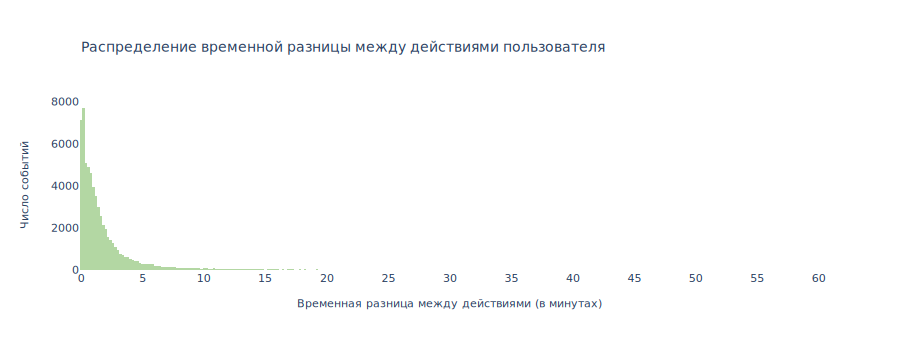

In [30]:
# построим график распределения временной разницы между действиями с учетом ограничения в 60 минут

fig = go.Figure(go.Histogram(x=events.query('diff_minutes < 60')['diff_minutes'],
                             marker_color=colours[1],
                             hoverinfo='x+y',
                             showlegend=False)
               )
fig.update_layout(height=350, width=900, plot_bgcolor='white', font_size=11,
                  title = {'text':'Распределение временной разницы между действиями пользователя',
                           'y':.88,
                           'x':0.09,
                           'font.size':14,
                          })
fig.update_xaxes(title='Временная разница между действиями (в минутах)', title_font_size=11, dtick=5)
fig.update_yaxes(title='Число событий', title_font_size=11)
fig.show()

Пауза между событиями редко превышает 10 минут, поэтому будем считать, что если пользователь совершает действие по истечении 10 минут с момента прошлого события, начинается новая сессия.

Разделим логи событий на сессии, создадим в датасете столбец с id сессии:

In [31]:
# проранжируем события: если прошло 10 минут от предыдущего действия, то такому действию присваиваем новый ранг
session_rang = (events['time_diff'] > pd.Timedelta('10Min')).cumsum()

# присвоим каждому событию id соответствующей сессии (в разрезе пользователей)
events['session_id'] = events.groupby(['user_id', session_rang]).ngroup() + 1

#### Продолжительность сессии

Рассчитаем продолжительность каждой сессии.  
Обращаем внимание, что для сессий с 1 событием расчетная продолжительность будет нулевой, но фактически это может быть не так: пользователь иногда совершает только 1 действие в приложении, но делает это в течение некоторого времени (просмотр рекомендованных объявлений, поиск).

In [32]:
# создадим технический столбец, в котором отметим нулём (False) строки датасета,
# где значения "user_id" или "session_id" изменились относительно предыдущей строки
events['old_user_session'] = ((events.user_id == events.user_id.shift()) &
                              (events.session_id == events.session_id.shift())
                             )

# умножив технический столбец на временную разницу между событиями,
# получим длительность каждого события в рамках сессии в разрезе пользователей
events['event_duration'] = (events['old_user_session'] * events['diff_minutes']).shift(-1)
events['event_duration'] = events['event_duration'].fillna(0)

# рассчитаем продолжительность каждой сессии
events['session_duration'] = events.groupby('session_id')['event_duration'].transform('sum')

# уберем из датасета технический столбец, а также вспомогательные столбцы time_diff и diff_minutes
events = events.drop(columns=['old_user_session', 'time_diff', 'diff_minutes'])

Посмотрим, сколько вышло сессий с нулевой продолжительностью, и каков процент таких сессий от общего числа:

In [33]:
print('Число сессий с нулевой расчетной продолжительностью - {}'
      .format(events.query('session_duration == 0')['session_id'].nunique())
     )

print('Процент таких сессий от общего числа - {:.2%}'
      .format(events.query('session_duration == 0')['session_id'].nunique() / 
              events['session_id'].nunique())
     )

Число сессий с нулевой расчетной продолжительностью - 3255
Процент таких сессий от общего числа - 25.65%


Количество сессий с нулевой расчетной продолжительностью существенное, и для анализа средней продолжительности теста не будем их учитывать, поскольку данные сессии исказят общую картину.  

Посмотрим на среднюю продолжительность сессий, за которую пользователь совершает несколько действий:

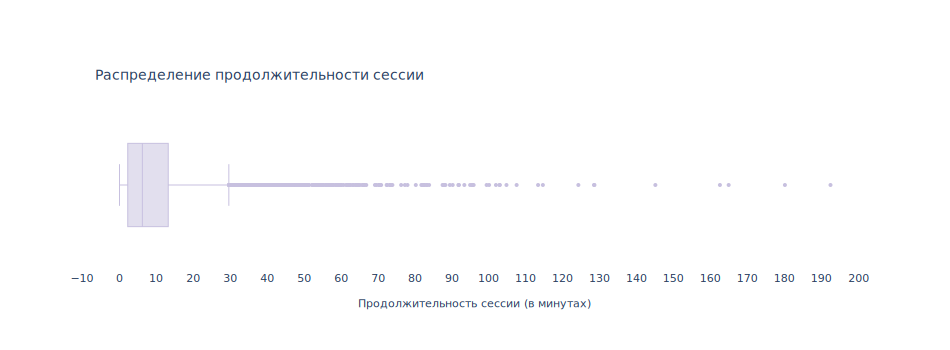

In [34]:
session_duration = events.query('session_duration != 0').groupby('session_id').agg({'session_duration':'mean'})

fig = go.Figure(go.Box(x=session_duration['session_duration'],
                       marker_color=colours[2],
                       hoverinfo='x',
                       showlegend=False,
                       name='',
                       marker_size=4,
                       line_width=1)
               )
fig.update_layout(height=350, width=950, plot_bgcolor='white', font_size=11,
                  title = {'text':'Распределение продолжительности сессии',
                           'y':.8,
                           'x':.1,
                           'font.size':14,
                          })
fig.update_xaxes(title='Продолжительность сессии (в минутах)', title_font_size=11, dtick=10)

fig.show()

**Наблюдения:** Типичная сессия с несколькими событиями длится в пределах 29.6 минут, медиана - 6.2 минуты. Также в логе встречаются выбросы - нехарактерно длинные сессии, самая продолжительная из которых составила 192 минуты.

#### Число событий в сессии

Посмотрим, сколько событий включает одна сессия:

In [35]:
# рассчитаем число событий в сессии
events_by_session = (events
                     .groupby('session_id', as_index=False)
                     .agg({'event_name':'count'})
                     .rename(columns={'event_name':'events_number'})
                    )

In [36]:
# построим график разброса числа событий в сессии

fig = go.Figure(go.Scatter(x=events_by_session['session_id'],
                           y=events_by_session['events_number'],
                           mode='markers',
                           marker=dict(size=6, color=events_by_session['events_number'],
                                       colorscale=colours[0:7]),
                           hoverinfo='y',
                           showlegend=False)
               )
fig.update_layout(height=450, width=900, plot_bgcolor='white', font_size=11,
                  title = {'text':'Разброс числа событий в сессии',
                           'y':.9,
                           'x':0.13,
                           'font.size':14,
                          })
fig.update_xaxes(title='Номер сессии', title_font_size=11, dtick=1000)
fig.update_yaxes(title='Количество событий в сессии', title_font_size=11, dtick=10, range=[0, 140])

fig.show()

In [37]:
# рассчитаем среднее число событий в сессии
print('Среднее число событий в сессии - {:.2f}'
      .format(events_by_session['events_number'].mean())
     )

# рассчитаем медианное число событий в сессии
print('Медианное число событий в сессии - {:.2f}'
      .format(events_by_session['events_number'].median())
     )

Среднее число событий в сессии - 5.85
Медианное число событий в сессии - 3.00


**Наблюдения:** В основном сессии включают до 10 событий, но наблюдаются и аномально насыщенные сессии с десятками событий.

#### Число сессий на пользователя

Посмотрим, сколько сессий приходится на одного пользователя:

In [38]:
# рассчитаем число сессий для каждого пользователя
sessions_by_user = (events
                    .groupby('user_id', as_index=False)
                    .agg({'session_id':'nunique'})
                    .rename(columns={'session_id':'sessions_number'})
                   )

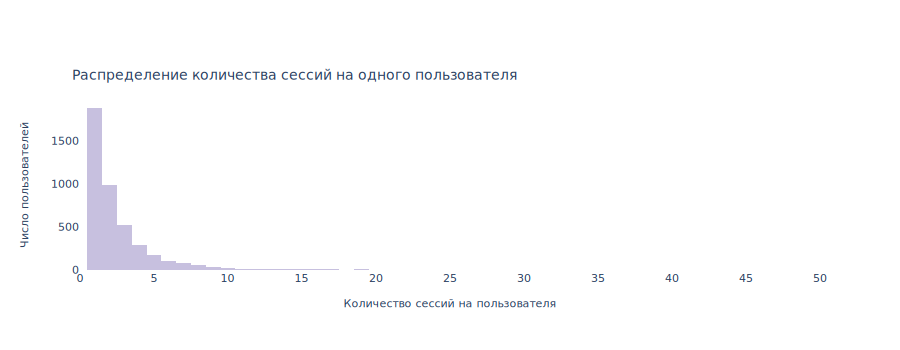

In [39]:
# построим график распределения количества сессий на одного пользователя

fig = go.Figure(go.Histogram(x=sessions_by_user['sessions_number'],
                             marker_color=colours[2],
                             hoverinfo='x+y',
                             showlegend=False)
               )
fig.update_layout(height=350, width=900, plot_bgcolor='white', font_size=11,
                  title = {'text':'Распределение количества сессий на одного пользователя',
                           'y':.8,
                           'x':0.08,
                           'font.size':14,
                          })
fig.update_xaxes(title='Количество сессий на пользователя', title_font_size=11, dtick=5, range=[0, 50])
fig.update_yaxes(title='Число пользователей', title_font_size=11)

fig.show()

In [40]:
# рассчитаем среднее число сессий на одного пользователя
print('Среднее число сессий на одного пользователя - {:.2f}'
      .format(sessions_by_user['sessions_number'].mean())
     )

# рассчитаем медианное число сессий на одного пользователя
print('Медианное число сессий на одного пользователя - {:.2f}'
      .format(sessions_by_user['sessions_number'].median())
     )

Среднее число сессий на одного пользователя - 2.96
Медианное число сессий на одного пользователя - 2.00


**Наблюдения:** Чуть меньше половины пользователей в рассматриваемом периоде (1877 человек из 4293) заходили в приложение лишь однажды. При этом есть небольшое число пользователей, которые провели 28 и более сессий - т.е. заходили в приложение минимум раз в день.

#### Перерыв между сессиями

Посмотрим, какой перерыв между сессиями делают пользователи:

In [41]:
# сохраним в отдельную таблицу информацию по сессиям пользователей, без детализации по действиям

sessions = (events.groupby(['user_id','session_id'], as_index=False)
            .agg({'session_duration':'mean', 'event_time':['first','last']})
            .droplevel(1, axis=1)
           )
sessions.columns = ['user_id', 'session_id', 'session_duration', 'session_start', 'session_end']
sessions = sessions.merge(profiles[['user_id','segment','dt']], on='user_id', how='left')

# рассчитаем время между сессиями для каждого пользователя

sessions['sessions_time_delta'] = ((sessions.user_id == sessions.user_id.shift())
                                   *(sessions['session_start'] - sessions['session_end'].shift())
                                  )
sessions['time_delta_hours'] = round(sessions['sessions_time_delta'].dt.total_seconds()/3600, 2)
sessions['time_delta_hours'] = sessions['time_delta_hours'].fillna(0)
sessions['time_delta_days'] = round(sessions['time_delta_hours']/24, 2)

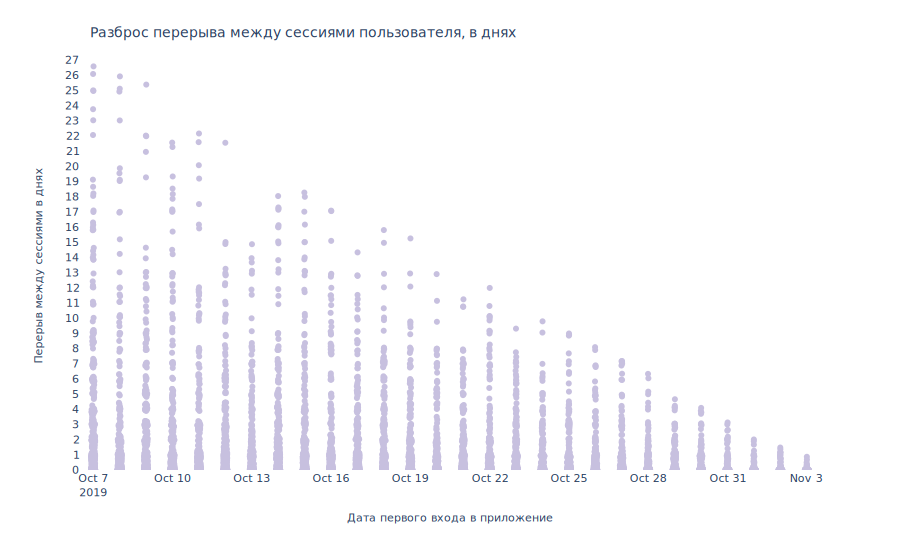

In [42]:
# построим график разброса перерыва между сессиями в разрезе даты первого посещения приложения
# при этом не будем учитывать первые сессии пользователей - расчетный перерыв для них равен 0

fig = px.strip(sessions.query('user_id == user_id.shift()'),
               x='dt',
               y='time_delta_days'
              )
fig.update_traces(marker_color=colours[2])
fig.update_layout(height=550, width=900, plot_bgcolor='white', font_size=11,
                  title = {'text':'Разброс перерыва между сессиями пользователя, в днях',
                           'y':.95,
                           'x':.1,
                           'font.size':14
                          })
fig.update_xaxes(title='Дата первого входа в приложение', title_font_size=11)
fig.update_yaxes(title='Перерыв между сессиями  в днях', title_font_size=11, dtick=1, range=[0, 27])
fig.show()

**Наблюдения:** Чаще всего перерыв между сессиями пользователя составляет менее 1 дня, т.е. многие пользователи, осуществившие несколько сессий, провели их в течение суток. Если пользователь возвращается в приложение более чем через сутки, то в основном перерыв составляет до 5 дней.

### Расчет Retention Rate

In [43]:
# функция для расчета retention rate

def get_retention(
    profiles,
    events,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False):

    # добавляем столбец contacts_viewed в передаваемый dimensions список
    dimensions = dimensions + ['contacts_viewed']

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем информацию по времени начала каждой сессии
    sessions = (events.groupby(['user_id', 'session_id'], as_index=False)
                .agg({'event_time':'first'})
                .rename(columns={'event_time':'session_start'})
               )
    # собираем «сырые» данные для расчета удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'})
                       )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [44]:
# дата анализа (observation_date) - последняя дата в логе

observation_date = events['dt'].max()

Построим хитмэп retention rate за весь период анализа для пользователей, осуществивших целевое действие:

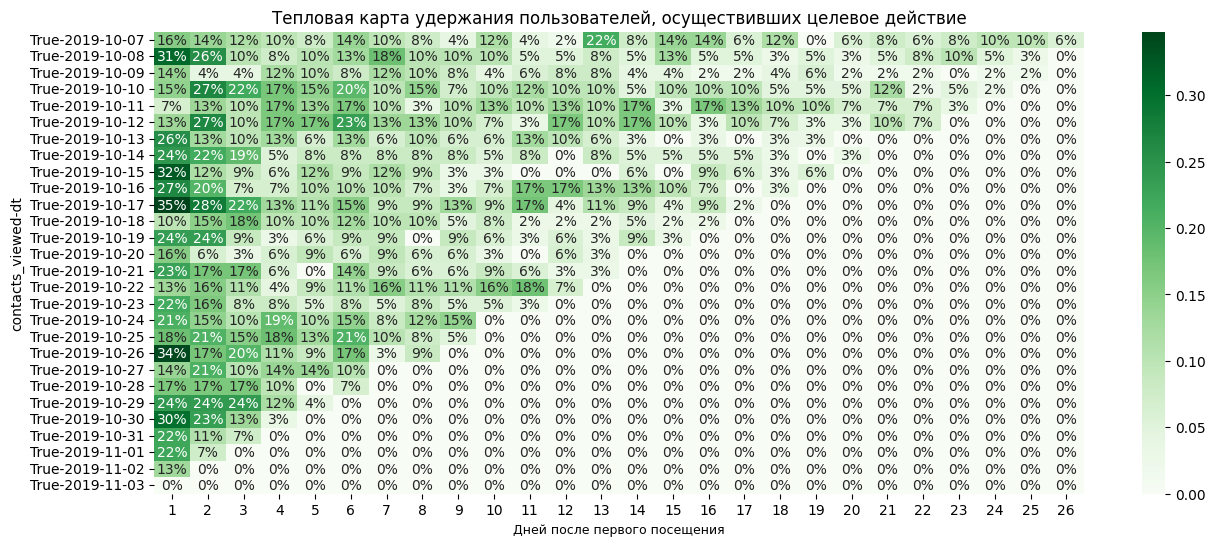

In [45]:
horizon_days = 27
retention_raw, retention, retention_history = get_retention(profiles, events, observation_date, horizon_days,
                                                            ignore_horizon=True)

plt.figure(figsize=(15, 6))
sns.heatmap(retention_history.query('contacts_viewed == True').drop(columns=['cohort_size', 0]),
            annot=True,
            fmt='.0%',
            cmap='Greens'
           )
plt.title('Тепловая карта удержания пользователей, осуществивших целевое действие')
plt.xlabel('Дней после первого посещения', fontsize=9)
plt.show()

**Наблюдения:** Retention rate пользователей, осуществивших целевое действие, различается по когортам, и в некоторых случаях удержание на 2-й, 3-й день и далее после первого посещения (не включая его) растет относительно удержания на 1-й день. Из хитмэпа выше видно, что динамика retention rate нелинейна и непостоянна: пользователи вновь заходят в приложение спустя несколько дней после его установки и периодически возвращаются.

Построим хитмэп retention rate за весь период анализа для пользователей, не осуществивших целевое действие:

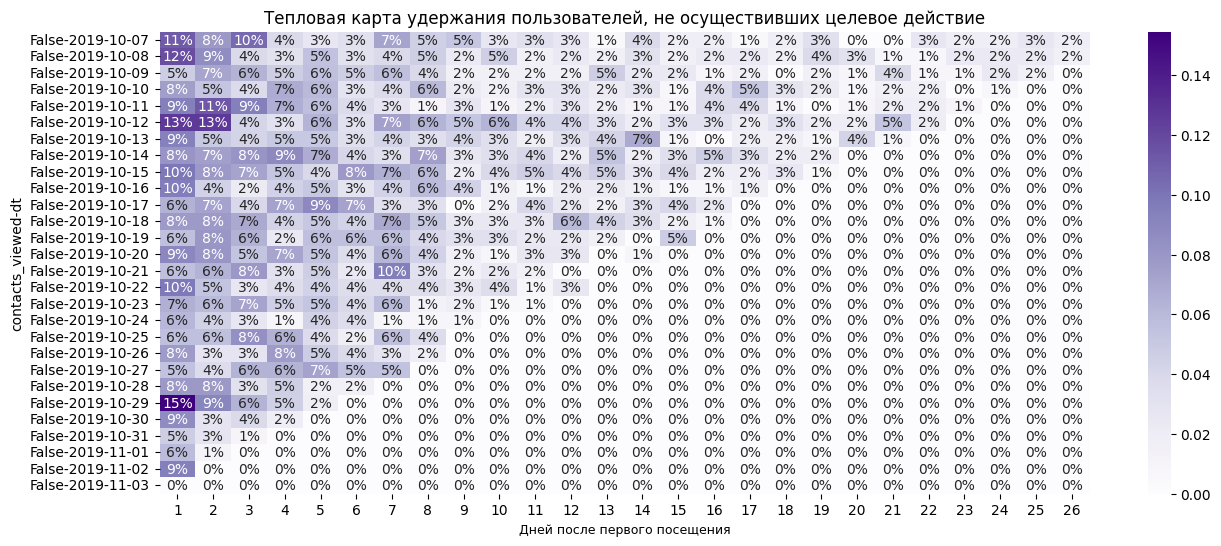

In [46]:
plt.figure(figsize=(15, 6))
sns.heatmap(retention_history.query('contacts_viewed == False').drop(columns=['cohort_size', 0]),
            annot=True,
            fmt='.0%',
            cmap='Purples'
           )
plt.title('Тепловая карта удержания пользователей, не осуществивших целевое действие')
plt.xlabel('Дней после первого посещения', fontsize=9)
plt.show()

**Наблюдения:** Retention rate пользователей, не осуществлявших целевое действие, ожидаемо ниже, чем у пользователей, смотревших контакты в объявлении. Динамика удержания также различается по когортам, нелинейна и непостоянна: пользователи периодически возвращаются.

In [47]:
# функция для визуализации динамики retention rate

def plot_retention(retention, retention_history, horizon):

    # задаём размер сетки для графиков
    # если горизонт расчета удержания - не весь период анализа, то
    # в таблице графиков — два столбца и две строки (четыре ячейки)
    # иначе - два столбца и одна строка (две ячейки)
    if horizon != (events['event_time'].max() - events['event_time'].min()).days:
        plt.figure(figsize=(15, 8))
    else:
        plt.figure(figsize=(15, 7))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history[[horizon - 1]]

    # если в индексах таблицы удержания только contacts_viewed,
    # добавляем в индекс второй признак (уровень) — "все пользователи"
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'contacts_viewed'])
        retention_history['cohort'] = 'All users'
        retention_history = retention_history.reset_index().set_index(['cohort', 'contacts_viewed'])

    # в первой ячейке строим кривые удержания пользователей, осуществивших целевое действие
    ax1 = plt.subplot(2, 2, 1)
    (retention.query('contacts_viewed == True').droplevel('contacts_viewed').T
     .plot(color=colours, grid=True, ax=ax1)
    )
    plt.xlabel('Лайфтайм')
    plt.legend(loc='upper right')
    plt.title('Удержание пользователей, осуществивших целевое действие')

    # во второй ячейке строим кривые удержания пользователей, не осуществивших целевое действие
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    (retention.query('contacts_viewed == False').droplevel('contacts_viewed').T
     .plot(color=colours, grid=True, ax=ax2)
    )
    plt.xlabel('Лайфтайм')
    plt.legend(loc='upper right')
    plt.title('Удержание пользователей, не осуществивших целевое действие')
    
    if horizon != (events['event_time'].max() - events['event_time'].min()).days:
        # в третьей ячейке — динамика удержания пользователей, осуществивших целевое действие
        ax3 = plt.subplot(2, 2, 3)
        # получаем названия столбцов для сводной таблицы
        columns = [name for name in retention_history.index.names
                   if name not in ['contacts_viewed','dt']
                  ]
        # фильтруем данные и строим график
        filtered_data = (retention_history.query('contacts_viewed == True')
                         .pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
                        )
        filtered_data.plot(color=colours, grid=True, ax=ax3)
        plt.xlabel('Дата привлечения')
        plt.legend(loc='upper right')
        plt.title('Динамика удержания пользователей,\n'+'осуществивших целевое действие, на {}-й день'
                  .format(horizon))
        
        # в чётвертой ячейке — динамика удержания пользователей, не осуществивших целевое действие
        ax4 = plt.subplot(2, 2, 4, sharey=ax3)
        # фильтруем данные и строим график
        filtered_data = (retention_history.query('contacts_viewed == False')
                         .pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
                        )
        filtered_data.plot(color=colours, grid=True, ax=ax4)
        plt.xlabel('Дата привлечения')
        plt.legend(loc='upper right')
        plt.title('Динамика удержания пользователей,\n'+'не осуществивших целевое действие, на {}-й день'
                  .format(horizon))
    
    plt.tight_layout()
    plt.show()

Пользователи, "прожившие" минимум 7 дней с момента первого посещения

Общее число "доживших" пользователей - 3548


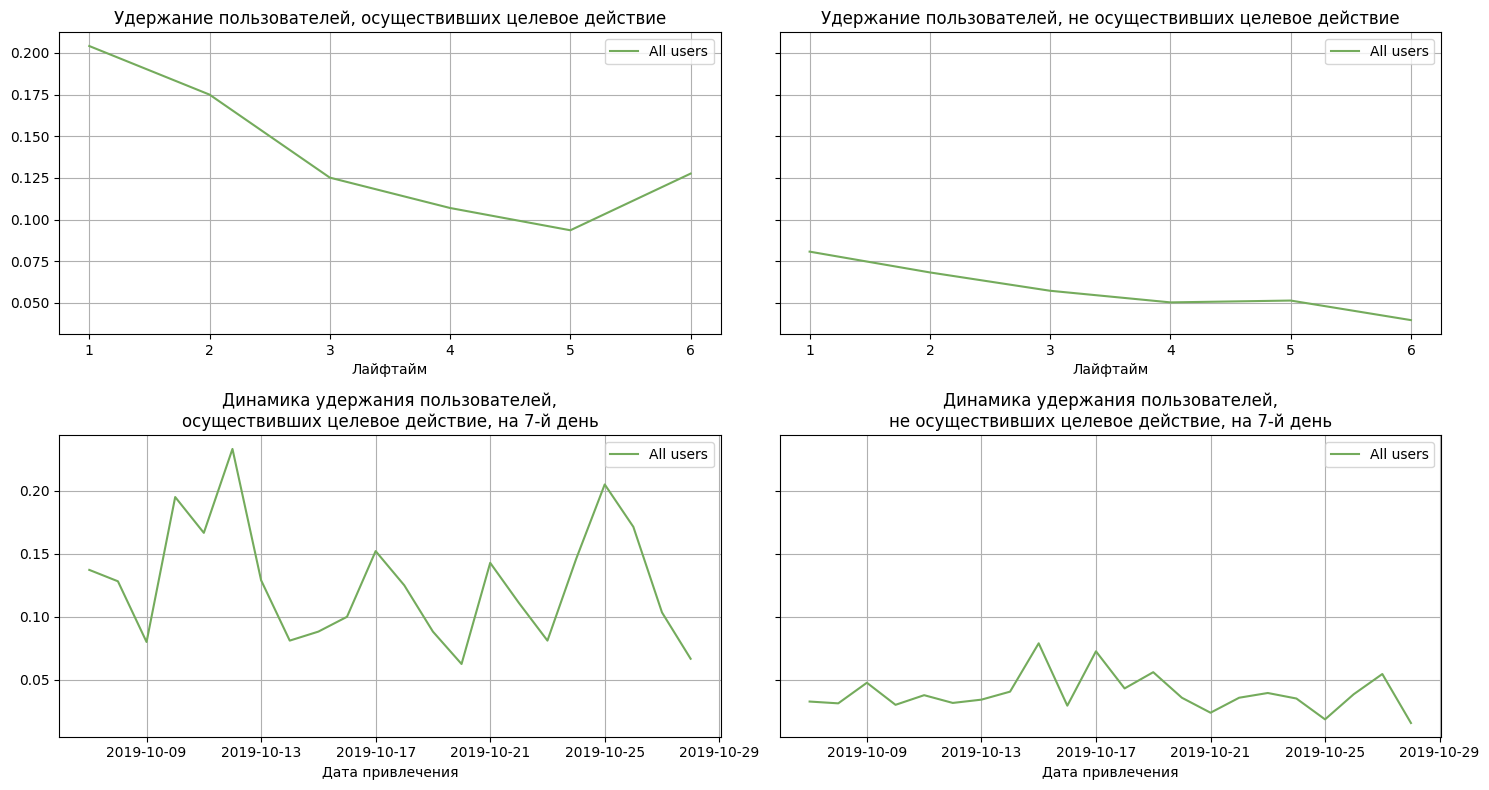

______________________________________________________________________________________________________________ 

Пользователи, "прожившие" минимум 14 дней с момента первого посещения

Общее число "доживших" пользователей - 2457


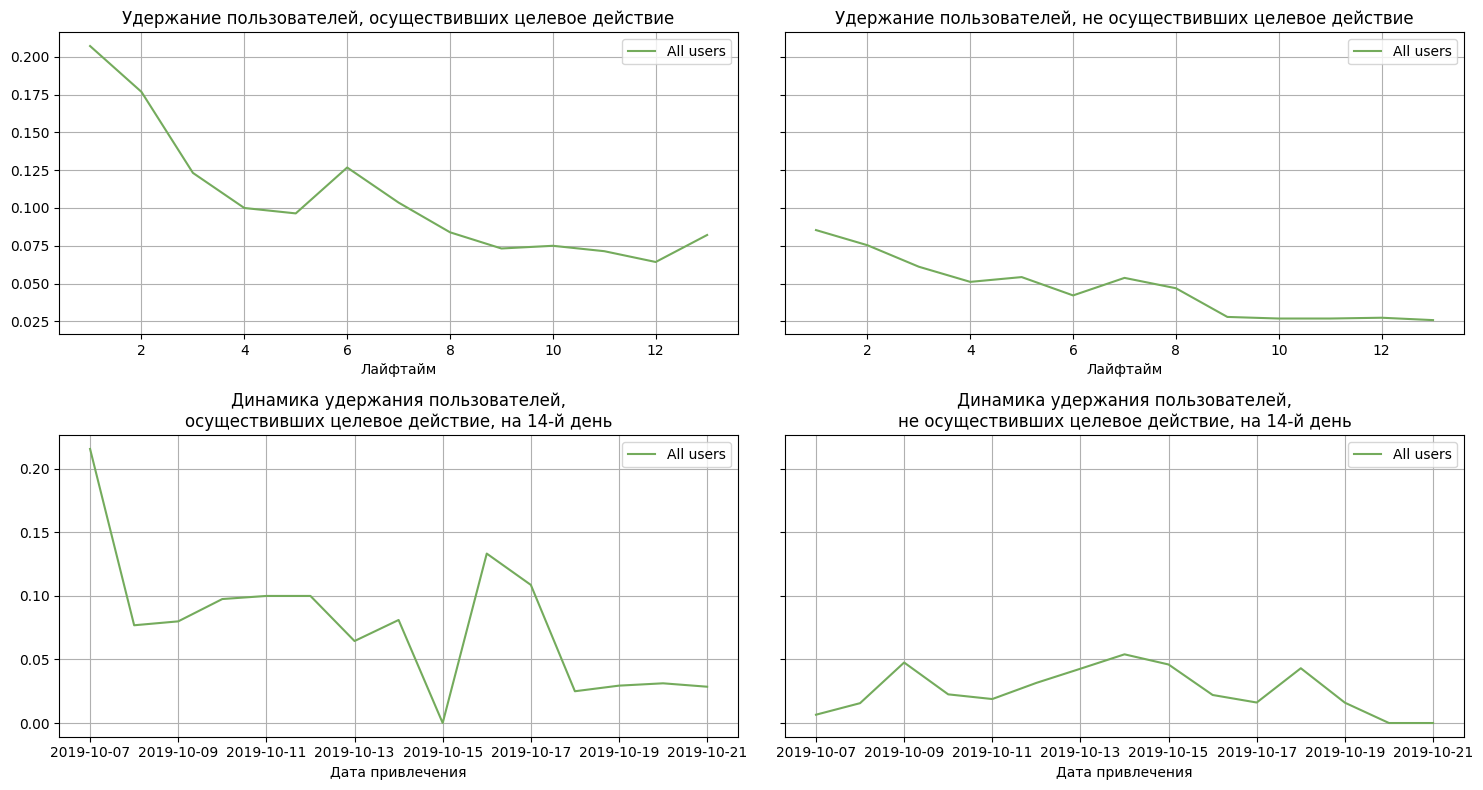

______________________________________________________________________________________________________________ 

Пользователи, "прожившие" минимум 21 дней с момента первого посещения

Общее число "доживших" пользователей - 1315


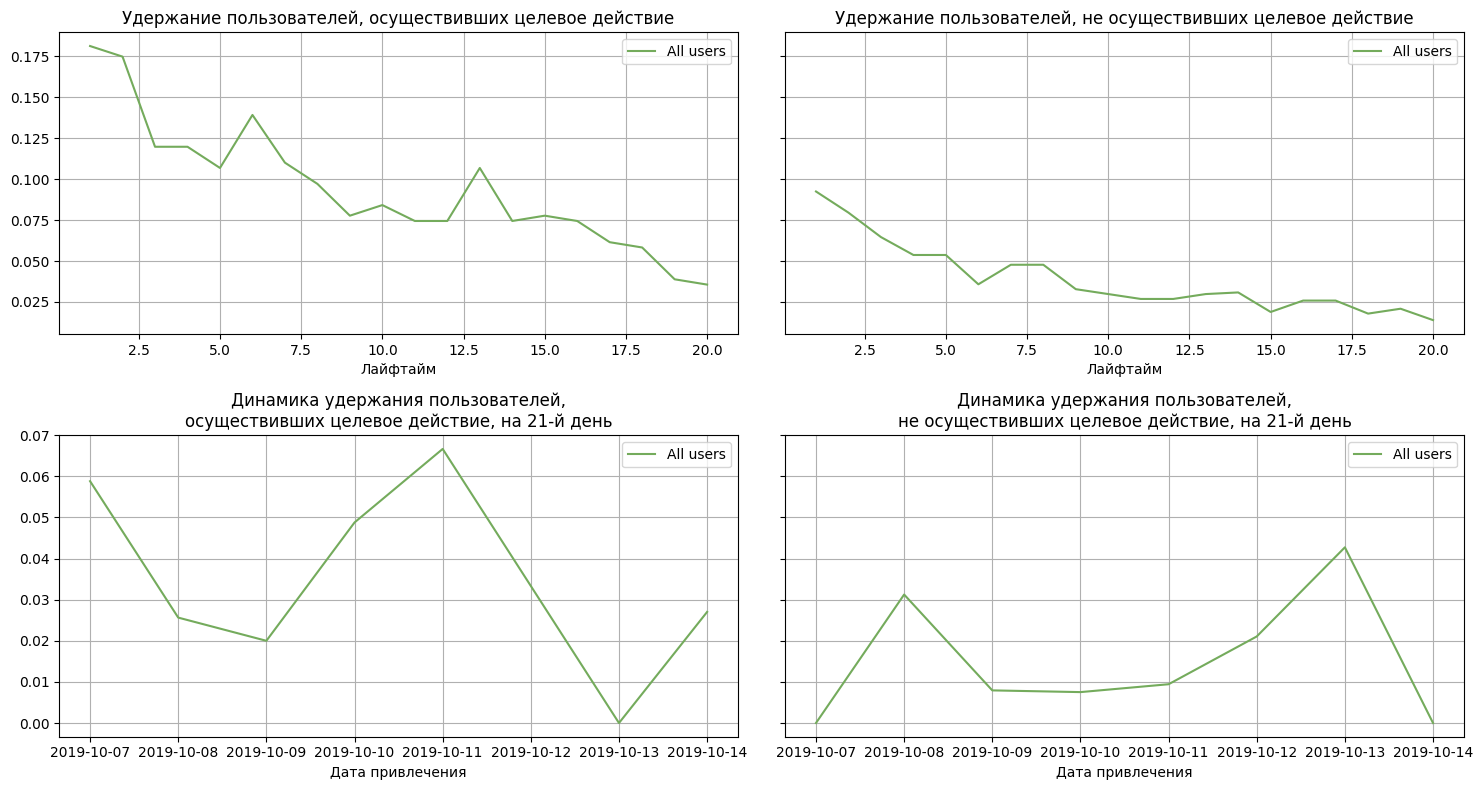

______________________________________________________________________________________________________________ 

Пользователи, "прожившие" минимум 27 дней с момента первого посещения

Общее число "доживших" пользователей - 371


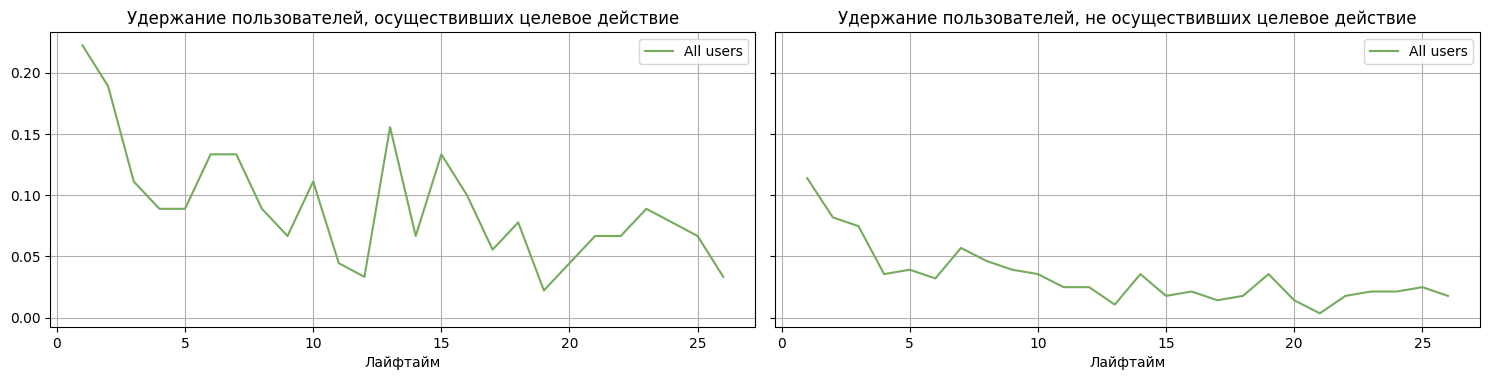

______________________________________________________________________________________________________________ 



In [48]:
# посмотрим общую динамику удержания пользователей, "проживших" 7, 14, 21 и 27 дней с момента первого посещения

for horizon_days in [7, 14, 21, 27]:
    retention_raw, retention, retention_history = get_retention(profiles, events, observation_date, horizon_days)
    print('Пользователи, "прожившие" минимум {} дней с момента первого посещения\n'.format(horizon_days))
    print('Общее число "доживших" пользователей - {}'.format(retention['cohort_size'].sum()))
    plot_retention(retention, retention_history, horizon_days)
    print('__'*55, '\n')

**Наблюдения:** На 7й день с момента первого посещения приложения (включительно) retention rate пользователей, осуществивших целевое действие, в среднем составил 12.5%, на 14й день - около 8%, на 21й день - около 3.5%, на 27й - около 3%. Данные показатели не отражают динамику удержания пользователей в целом: графики выше подтверждают наши выводы на основе хитмэпа о том, что динамика retention rate непостоянна, и удержание периодически растет в течение лайфтайма, поскольку пользователи возвращаются в приложение. Общая картина такова, что первые 5 дней удержание падает, а потом его динамика приобретает хаотичный характер с тенденцией к снижению.

### Расчет конверсии

In [49]:
# функция для расчета конверсии

def get_conversion(
    profiles,
    events,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # собираем информацию по времени начала каждой сессии
    sessions = (events.groupby(['user_id', 'session_id'], as_index=False)
                .agg({'event_time':'first'})
                .rename(columns={'event_time':'session_start'})
               )
    # определяем дату и время первого выполнения целевого действия для каждого пользователя
    first_contacts_show = (events.query('event_name_new == "contacts_show"')
                           .groupby('user_id')
                           .agg({'event_time': 'first'})
                           .rename(columns={'event_time':'first_contacts_show'})
                           .reset_index()
                          )
    # собираем «сырые» данные для расчета конверсии
    result_raw = result_raw.merge(first_contacts_show[['user_id', 'first_contacts_show']],
                                  on='user_id', how='left')
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['target_lifetime'] = (result_raw['first_contacts_show'] - result_raw['first_ts']).dt.days
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    result_raw['first_view'] = (result_raw['target_lifetime'] == result_raw['lifetime'])

    # группируем по всем пользователям, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        dims_contacts_show = dims + ['first_view']
        result = (df.pivot_table(index=dims_contacts_show, columns='lifetime', values='user_id',
                                 aggfunc='nunique')
                  .query('first_view == True')
                  .fillna(0)        
                 )
        result.index = result.index.droplevel(-1)
        result = result.cumsum(axis = 1)
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'})
                       )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую ячейку в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [50]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 3))
    
    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history[[horizon - 1]]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(color=colours, grid=True, ax=ax1)
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    plt.legend(loc='upper right')

    # второй график — динамика конверсии
    if horizon != (events['event_time'].max() - events['event_time'].min()).days:
        ax2 = plt.subplot(1, 2, 2, sharey=ax1)
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        columns = [name for name in conversion_history.index.names if name not in ['dt']]
        filtered_data = (conversion_history
                         .pivot_table(index='dt', columns=columns, values=horizon-1, aggfunc='mean')
                        )
        filtered_data.plot(color=colours, grid=True, ax=ax2)
        plt.xlabel('Дата привлечения')
        plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
        plt.legend(loc='upper right')
    else:
        ax2 = plt.subplot(1, 2, 2)
        ax2.tick_params(bottom=False, left=False)
        ax2.set(xticklabels=[], yticklabels=[])
        plt.box(on=None)

    plt.tight_layout()
    plt.show()

Пользователи, "прожившие" минимум 7 дней с момента первого посещения

Общее число "доживших" пользователей - 3548


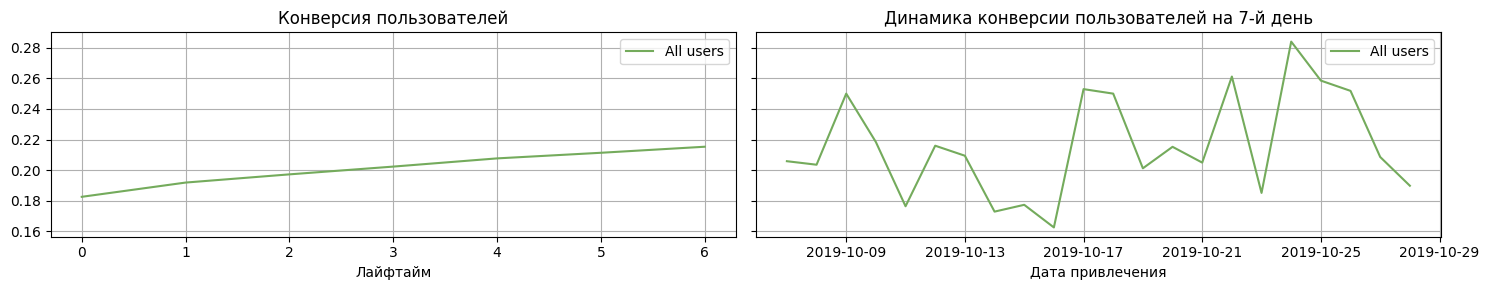

______________________________________________________________________________________________________________ 

Пользователи, "прожившие" минимум 14 дней с момента первого посещения

Общее число "доживших" пользователей - 2457


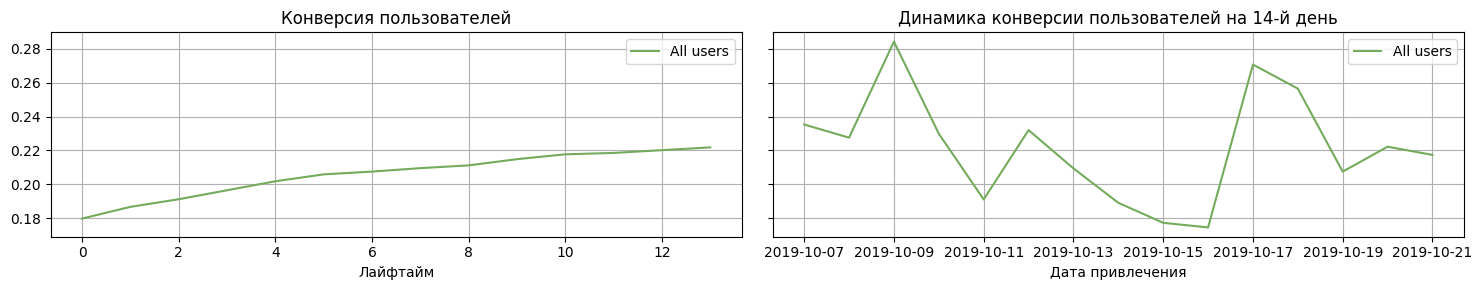

______________________________________________________________________________________________________________ 

Пользователи, "прожившие" минимум 21 дней с момента первого посещения

Общее число "доживших" пользователей - 1315


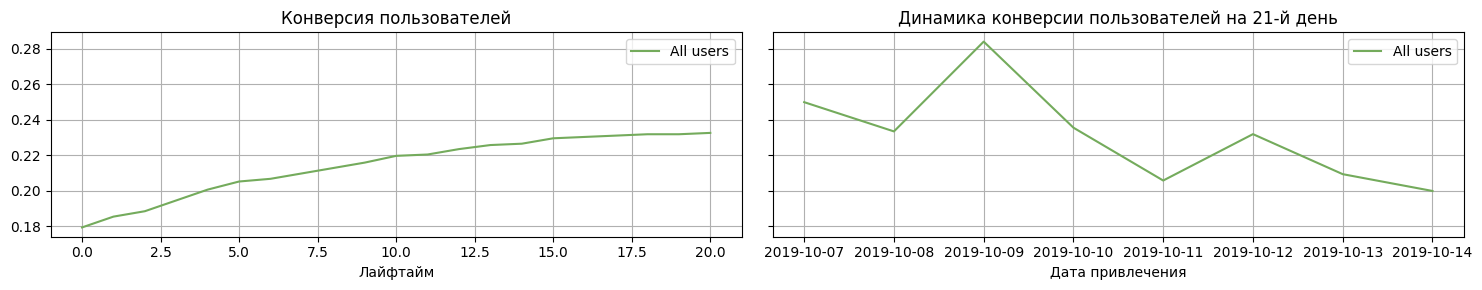

______________________________________________________________________________________________________________ 

Пользователи, "прожившие" минимум 27 дней с момента первого посещения

Общее число "доживших" пользователей - 371


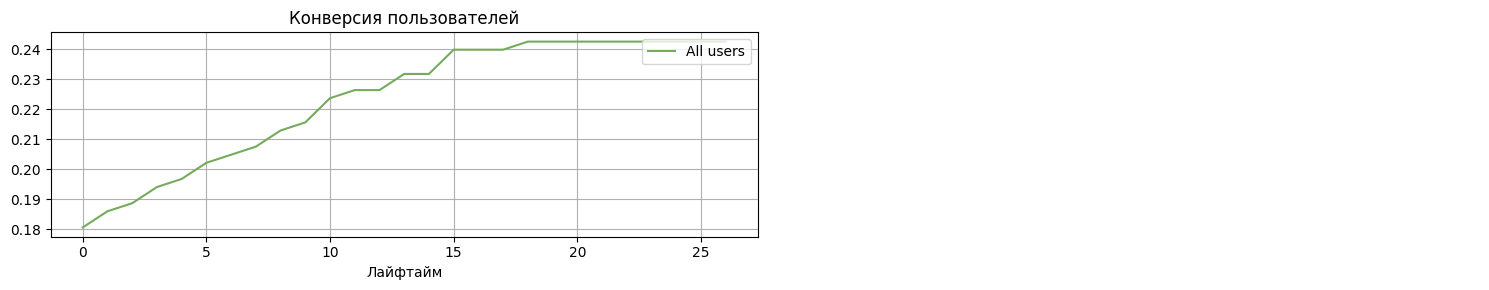

______________________________________________________________________________________________________________ 



In [51]:
# посмотрим общую динамику конверсии пользователей, "проживших" 7, 14, 21 и 27 дней с момента первого посещения

for horizon_days in [7, 14, 21, 27]:
    conversion_raw, conversion, conversion_history = get_conversion(profiles, events,
                                                                    observation_date, horizon_days)
    print('Пользователи, "прожившие" минимум {} дней с момента первого посещения\n'.format(horizon_days))
    print('Общее число "доживших" пользователей - {}'.format(conversion['cohort_size'].sum()))
    plot_conversion(conversion, conversion_history, horizon_days)
    print('__'*55, '\n')

**Наблюдения:** На 7й день с момента первого посещения приложения (включительно) конверсия пользователей в среднем составила ок. 21.5%, на 14й день - чуть больше 22%, на 21й день - около 23%, на 27й - чуть больше 24%. В целом после 10го дня с момента первого посещения приложения темп роста конверсии снижается.

In [52]:
# посмотрим на общую конверсию в целевое событие за анализируемый период

print('Общая конверсия в целевое событие за анализируемый период - {:.2%}'
     .format(events.query('event_name_new == "contacts_show"')['user_id'].nunique()
             / events['user_id'].nunique())
     )

Общая конверсия в целевое событие за анализируемый период - 22.85%


----

**Общий вывод:** Данные были представлены за 4 недели (27 полных дней) с 7 октября 2019 г. Мы разделили события на сессии и проанализировали поведение пользователей в приложении. Основные наблюдения следующие:
- Пользователи в основном находят приложение через поисковик Yandex.
- Число событий растет с началом рабочего дня и немного снижается после окончания рабочего дня (17-18 часов), когда пользователи находятся в пути домой. Пик пользовательской активности за день приходится на время обеда (14-16 часов) и вечер (20-21 час).
- Число событий в целом не зависит от дня недели, однако общее количество действий, совершенных в пятницу и субботу, в анализируемом периоде меньше, чем в остальные дни.
- Наиболее частое событие - просмотр рекомендованных объявлений (tips_show), на него приходится более половины всех событий в логе. Целевое действие - просмотр контактов (contacts_show) - составляет 6.1% событий в логе.
- Основная масса пользователей осуществляет от 3 до 15 действий в приложении, наиболее часто - 5 действий.
- Типичная сессия длится в пределах 29.6 минут и включает до 10 событий, медианная продолжительность - 6.2 минуты.
- Чуть меньше половины пользователей в рассматриваемом периоде (1877 человек из 4293) заходили в приложение лишь однажды. Медианное число сессий на пользователя - 2.
- Чаще всего перерыв между сессиями пользователя составляет менее 1 дня, т.е. многие пользователи, осуществившие несколько сессий, провели их в течение суток. В то же время пользователи нередко возвращаются в приложение и через несколько дней/недель с момента последней сессии, из-за чего динамика retention rate нелинейна и непостоянна.
- Retention rate пользователей, смотревших контакты в объявлениях, ожидаемо выше пользователей, не осуществивших целевое действие.
- Общая конверсия за рассматриваемый период составила 22.85%.

<a id='segmentation'></a>
## Сегментирование пользователей

**Подход к сегментированию:**  
Мы исследовали основные метрики в предыдущем разделе и предлагаем использовать для сегментации два параметра:
- признак совершения пользователем целевого действия (просмотр контактов),
- количество сессий пользователя (1 сессия или больше).

Выбор данных параметров обусловлен следующим:
- Совершение пользователем целевого действия означает понимание им принципа работы приложения и осознание пользы продукта. Таких пользователей легче возвращать в приложение, и это можно осуществлять собственными силами (например, пуш-уведомления и рассылки по электронной почте, в зависимости от даты последней сессии).
- Пользователи, не совершившие целевое событие, требуют больше внимания и затрат: более частых рассылок и пуш-уведомлений, промо-акций в виде скидки на доставку, ретаргетинг.
- Количество сессий показывает заинтересованность пользователя. Чем выше интерес, тем легче удержать пользователя. Как мы выявили в ходе анализа, почти половина пользователей заходила в приложение только 1 раз, и таких пользователей сложнее заинтересовать: возвращение в приложение тех из них, кто не осуществлял целевое действие, может стоить столько же, сколько привлечение новых пользователей.
- Нет оснований считать, что пользователи активны в разное время суток, разные дни недели, что на активность влияет источник ссылки на приложение, и что конверсия зависит от данных параметров.
- Нет оснований считать, что для пользователя характерна определенная продолжительность сессии: один и тот же человек может осуществлять как короткие, так и длинные сессии.
- Продолжительность сессии также необязательно влияет на конверсию: пользователь может провести более длинные сессии в поиске/обзоре рынка, а на покупку (просмотр контактов) решится, проведя короткую сессию и использовав фильтрацию в поиске на основе предварительного обзора рынка. Кроме того, долгий поиск подходящего объявления может привести к увеличению сомнений в выборе и в необходимости покупки.
- Нет оснований считать, что для пользователя характерно определенное число действий за одну сессию, поскольку поведение пользователей в приложении хаотично: за одну сессию можно воспользоваться несколькими поисковыми фильтрами, картой, рекомендациями, кликнуть на несколько объявлений и т.д., а за другую - долго скроллить рекомендации, по сути осуществив одно действие. Следовательно, и уровень конверсии не связан с количеством событий.  

Следовательно, при выделении сегментов мы апеллировали к сложности и стоимости удержания пользователей и их возвращения в приложение.

Таким образом, получим 4 сегмента:  
**Целевой аудиторией** будем считать активных пользователей (осуществивших несколько сессий), которые смотрели контакты в объявлении минимум 1 раз.    
**Вторая категория** - пользователи, которые еще не осуществляли целевое действие, но активны в приложении (провели несколько сессий). Такие пользователи явно проявляют интерес к приложению и, вероятно, позже конвертируются в целевую аудиторию.  
**Третья категория** - пользователи, смотревшие контакты в объявлении, но заходившие в приложение лишь 1 раз. Возможно, некоторые из этих пользователей переходили на контакты в объявлении по прямым ссылкам (например, из поиска в браузере) и в целом не намерены активно пользоваться приложением.   
**Четвертая категория** - пользователи, заходившие в приложение только 1 раз и не смотревшие контакты в объявлении.

In [53]:
# составим список пользователей, которые осуществляли целевое действие
users_with_contacts_viewed = list(profiles.query('contacts_viewed == True')['user_id'])

# составим список пользователей, которые совершили больше 1 сессии
users_over_1_session = list(sessions_by_user.query('sessions_number > 1')['user_id'])

In [54]:
# разделим пользователей на сегменты
user_segments = profiles[['user_id', 'segment']]

for user in user_segments['user_id']:
    if (user in users_with_contacts_viewed) and (user in users_over_1_session):
        user_segments.loc[user_segments['user_id'] == user, 'segment'] = 1
    elif (user not in users_with_contacts_viewed) and (user in users_over_1_session):
        user_segments.loc[user_segments['user_id'] == user, 'segment'] = 2
    elif (user in users_with_contacts_viewed) and (user not in users_over_1_session):
        user_segments.loc[user_segments['user_id'] == user, 'segment'] = 3
    elif (user not in users_with_contacts_viewed) and (user not in users_over_1_session):
        user_segments.loc[user_segments['user_id'] == user, 'segment'] = 4
    else:
        user_segments.loc[user_segments['user_id'] == user, 'segment'] = 'error'

In [55]:
# посмотрим на размер каждого сегмента
print('Размеры сегментов:')
display(user_segments['segment'].value_counts())

# посмотрим, какая доля пользователей приходится на целевую группу 1
print('Доля целевого сегмента - {:.2%}'
      .format(len(user_segments.query('segment == 1'))/len(user_segments))
     )

Размеры сегментов:


2    1689
4    1623
1     727
3     254
Name: segment, dtype: int64

Доля целевого сегмента - 16.93%


**Наблюдения:** Самый крупный сегмент - 2: пользователи, которые еще не осуществляли целевое действие, но провели несколько сессий. Меньше всего пользователей приходится на сегмент 3: осуществили целевое действие, но заходили в приложение лишь 1 раз. В целевую группу 1 вошло 727 человек (ок. 17% всех пользователей).

----

Посмотрим на распределение количества сессий одного пользователя сегментов 1 и 2 по дате первого входа в приложение:

In [56]:
# добавим данные по сегментам в основной датасет events

events['segment'] = events.merge(user_segments, on='user_id', how='left')['segment_y']

In [57]:
# обновим профили пользователей

profiles = get_profiles(events)

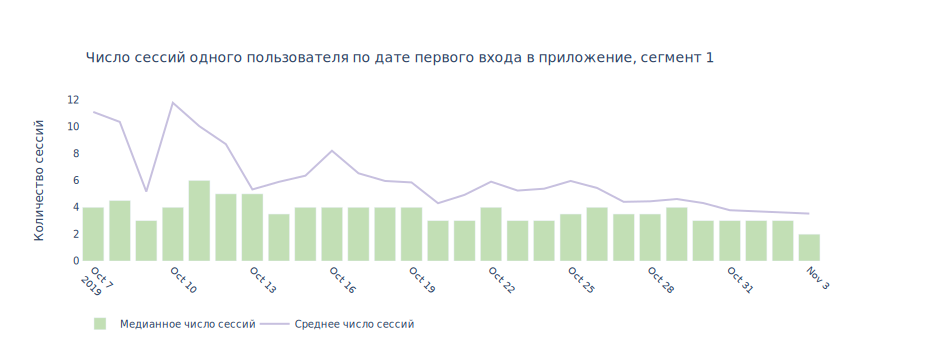

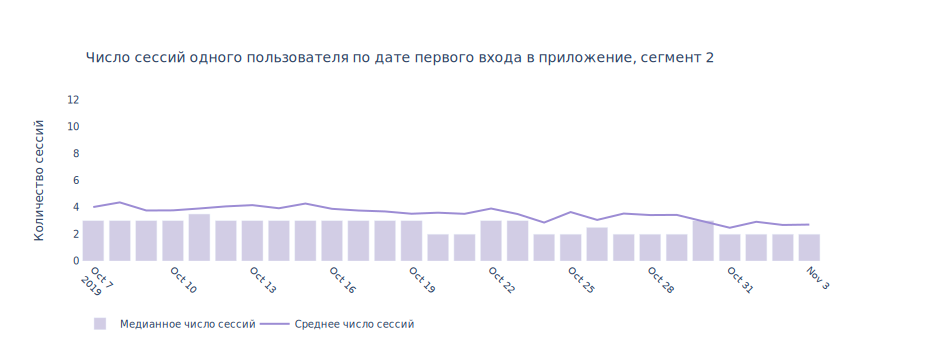

In [58]:
# группируем данные
sessions_by_first_dt = (profiles[['user_id','segment','dt']]
                        .merge(sessions_by_user, on='user_id', how='left').sort_values(by='dt')
                        .groupby(['segment','dt'], as_index=False)
                        .agg({'sessions_number':['median','mean']})
                        .droplevel(1, axis=1)
                       )
sessions_by_first_dt.columns = ['segment', 'dt', 'sessions_median', 'sessions_mean']

# строим график
for i in [1, 2]:
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Bar(x=sessions_by_first_dt.query('segment == @i')['dt'],
                         y=sessions_by_first_dt.query('segment == @i')['sessions_median'],
                         marker_color=colours[i],
                         name='Медианное число сессий',
                         opacity=.8)
                 )
    fig.add_trace(go.Scatter(x=sessions_by_first_dt.query('segment == @i')['dt'],
                             y=sessions_by_first_dt.query('segment == @i')['sessions_mean'],
                             mode='lines',
                             name='Среднее число сессий',
                             marker_color=colours[i+1]),
                  secondary_y=True)

    fig.update_yaxes(secondary_y=False, title_text='Количество сессий', range=[0, 12], dtick=2)
    fig.update_yaxes(secondary_y=True, range=[0, 12], visible=False)
    fig.update_layout(height=350, width=950, plot_bgcolor='white', font_size=10,
                      title={'text':
                             ('Число сессий одного пользователя по дате первого входа в приложение, сегмент {}'
                              .format(i)),
                              'y':.85,
                              'x':.09,
                              'font.size':14},
                      legend=dict(orientation='h', y=-.3, x=0))
    fig.update_xaxes(tickangle=45)
    fig.show()

**Наблюдения:** Пользователи целевого сегмента активнее пользователей сегмента 2: и медианное, и среднее число сессий на пользователя выше.

----

Посмотрим на распределение пользователей 3 и 4 сегментов по дате первого посещения. Таким образом выясним, не состоят ли данные сегменты большей частью из пользователей, зарегистрировавшихся в приложении в последние несколько дней периода анализа:

In [59]:
# добавим информацию по сегментам в датасет с сессиями

sessions['segment'] = sessions.merge(user_segments, on='user_id', how='left')['segment_y']

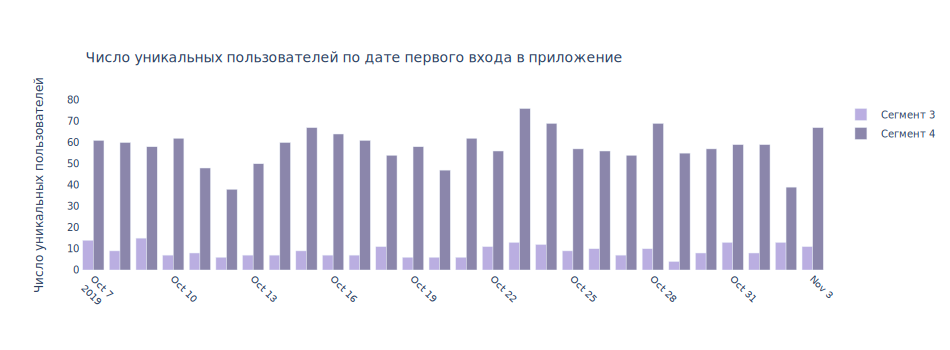

In [60]:
# группируем данные
unique_users_by_dt = (sessions.groupby(['segment', 'dt'], as_index=False).agg({'user_id':'nunique'}))

# строим график
fig = go.Figure()

for i in [3, 4]:
    fig.add_trace(go.Bar(x=unique_users_by_dt.query('segment == @i')['dt'],
                         y=unique_users_by_dt.query('segment == @i')['user_id'],
                         marker_color=colours[i],
                         name='Сегмент {}'.format(i),
                         opacity=.7)
                 )
    
fig.update_layout(height=350, width=950, plot_bgcolor='white', font_size=10,
                      title={'text':
                             ('Число уникальных пользователей по дате первого входа в приложение'),
                              'y':.85,
                              'x':.09,
                              'font.size':14}
                 )
fig.update_yaxes(title_text='Число уникальных пользователей', dtick=10)
fig.update_xaxes(tickangle=45)

fig.show()

**Наблюдения:** Размер сегментов 3 и 4 не искажен пользователями, зарегистрировавшимися в приложении в конце периода анализа. Можем считать, что данные сегменты пользователей действительно не проявили большой интерес к приложению.

----

Исходя из анализа удержания пользователей в предыдущем разделе (п. 3.10), пользователи, смотревшие контакты, возвращаются в приложение чаще, чем пользователи, не осуществившие целевое действие. Проверим, что это справедливо и для сегментов 1 и 2.  
Сегменты 3 и 4 не смотрим, т.к. данные пользователи совершили только 1 сессию, следовательно, их удержание на дату анализа равно 0.

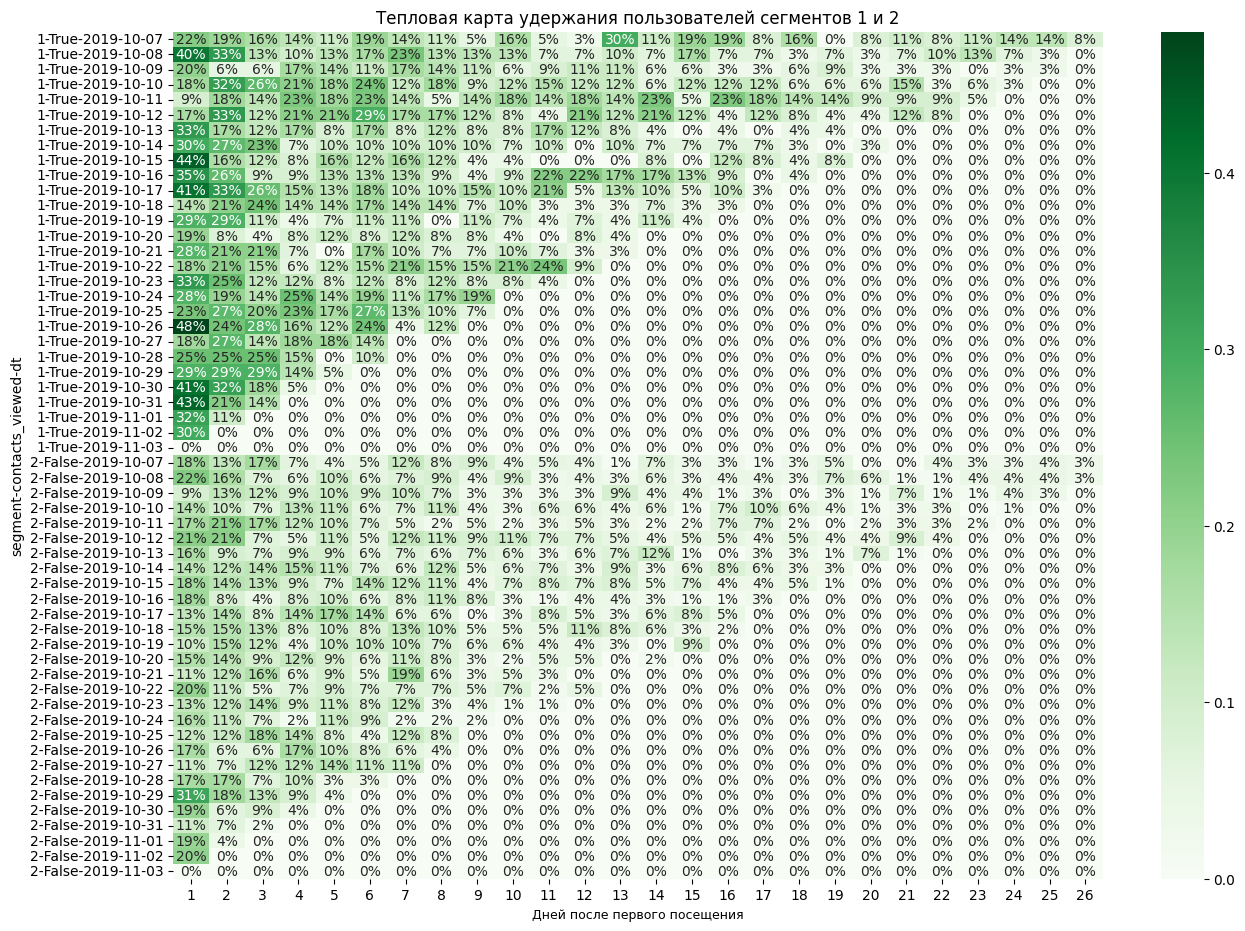

In [61]:
# построим хитмэп retention rate за весь период анализа для сегментов 1 и 2

horizon_days = 27
retention_raw, retention, retention_history = get_retention(profiles, events, observation_date, horizon_days,
                                                            dimensions=['segment'],
                                                            ignore_horizon=True)
plt.figure(figsize=(15, 11))
sns.heatmap(retention_history.query('segment == 1 or segment == 2').drop(columns=['cohort_size', 0]),
            annot=True,
            fmt='.0%',
            cmap='Greens'
           )
plt.title('Тепловая карта удержания пользователей сегментов 1 и 2')
plt.xlabel('Дней после первого посещения', fontsize=9)
plt.show()

**Наблюдения:** Удержание пользователей сегмента 1 действительно выше сегмента 2.

----

**Общий вывод:** Мы разделили пользователей на 4 сегмента, апеллируя к сложности/стоимости их удержания и возвращения в приложение. Критерии для деления на сегменты: 1) выполнение целевого действия, 2) количество сессий пользователя (1 сессия или больше).  

В итоге удалось выделить целевой сегмент 1: пользователи, которые смотрели контакты хотя бы раз (конверсия сегмента - 100%) и возвращались в приложение несколько раз. Удержание и активность пользователей данного сегмента выше сегмента 2.  
Удержание сегментов 3 и 4 нулевое, поскольку пользователи заходили в приложение лишь однажды.

<a id='AB_test'></a>
## Проверка гипотез

**Подход к анализу А/В-теста**  
Сравнивать группы будем по долям пользователей, совершивших целевое событие, к общему числу пользователей группы. За горизонт анализа возьмем 7, 14, 21 и 27 дней.  

Для сравнения долей двух генеральных совокупностей по выборкам из них применяется z-тест:  
*Нулевая гипотеза Н0: доля пользователей, совершивших событие (от общего числа пользователей группы), не отличается между группами теста.  
Альтернативная гипотеза Н1: доля пользователей, совершивших событие (от общего числа пользователей группы), различается между группами теста.*

In [62]:
# объявим функцию для расчета p-value и оценки статистической значимости различий между группами

def ztest_analysis(df, group1, group2, alpha):
    conv_rate_1 = df.query('index == @group1')[horizon_days-1].iloc[0]
    conv_rate_2 = df.query('index == @group2')[horizon_days-1].iloc[0]
    cohort_1 = df.query('index == @group1')['cohort_size'].iloc[0]
    cohort_2 = df.query('index == @group2')['cohort_size'].iloc[0]
    
    successes = np.array([conv_rate_1 * cohort_1, conv_rate_2 * cohort_2])
    trials = np.array([cohort_1, cohort_2])
    p_value = proportions_ztest(successes, trials)[1]
    
    print('Конверсия группы {}: {:.1%}'.format(group1, conv_rate_1))
    print('Конверсия группы {}: {:.1%}'.format(group2, conv_rate_2))
    print('p-value = {:.5f}'.format(p_value))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

**Корректировка уровня значимости**  
В целом нам предстоит выполнить 8 проверок на одних и тех же данных: две гипотезы, каждая по 4-м горизонтам анализа. Таким образом, наш тест является множественным, и с каждой новой проверкой гипотезы растет вероятность ошибки первого рода (Н0 отвергается, когда на самом деле различий между сравниваемыми группами нет).  

Чтобы снизить вероятность ошибки первого рода, скорректируем уровень значимости alpha по методу Шидака. Он не так грубо снижает alpha для одного теста, как простой метод Бонферрони: чем ниже уровень значимости, тем ниже мощность теста, и тем больше различий между группами можно упустить. За базовый уровень значимости возьмем 0.05.

In [63]:
# корректируем alpha

alpha = .05
alpha_sidak = 1 - (1 - alpha)**(1/8)

In [64]:
alpha_sidak

0.006391150954545011

### Различие конверсии по источникам ссылки на приложение

Некоторые пользователи установили приложение по ссылке из yandex, другие — из google.  
Н0: Две эти группы демонстрируют одинаковую конверсию в просмотры контактов.  
Н1: Две эти группы демонстрируют разную конверсию в просмотры контактов.

In [65]:
# тестируем гипотезы

for horizon_days in [7, 14, 21, 27]:
    conversion_raw, conversion, conversion_history = get_conversion(profiles, events, observation_date,
                                                                    horizon_days, dimensions=['source'])
    print('Пользователи, "прожившие" минимум {} дней с момента первого посещения:'.format(horizon_days))
    ztest_analysis(conversion, 'yandex', 'google', alpha_sidak)
    print()

Пользователи, "прожившие" минимум 7 дней с момента первого посещения:
Конверсия группы yandex: 23.1%
Конверсия группы google: 23.3%
p-value = 0.89319
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Пользователи, "прожившие" минимум 14 дней с момента первого посещения:
Конверсия группы yandex: 24.1%
Конверсия группы google: 22.4%
p-value = 0.43899
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Пользователи, "прожившие" минимум 21 дней с момента первого посещения:
Конверсия группы yandex: 27.3%
Конверсия группы google: 20.6%
p-value = 0.02283
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Пользователи, "прожившие" минимум 27 дней с момента первого посещения:
Конверсия группы yandex: 29.9%
Конверсия группы google: 20.6%
p-value = 0.10117
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Наблюдения:** Установка приложения через разные ссылки - yandex и google - не влияет на конверсию в целевое событие.

### Различие конверсии по времени, проведенном в приложении

Н0: Пользователи с разным количеством сессий демонстрируют одинаковую конверсию в просмотры контактов.  
Н1: Пользователи с разным количеством сессий демонстрируют разную конверсию в просмотры контактов.

Распределим пользователей на группы А и В по количеству их сессий: если количество сессий пользователя ниже либо равно медиане по всем пользователям, то присваиваем пользователю группу А, если выше - группу В.

In [66]:
# используем датафрейм "sessions_by_user"

sessions_by_user['ab_group'] = (sessions_by_user['sessions_number']
                                <= sessions_by_user['sessions_number'].median()
                               )
sessions_by_user['ab_group'] = sessions_by_user['ab_group'].replace({True:'A', False:'B'})

In [67]:
# посмотрим на размеры групп: насколько группа А, включающая медиану, больше группы В

sessions_by_user['ab_group'].value_counts()

A    2860
B    1433
Name: ab_group, dtype: int64

Группа А больше группы В в 2 раза, однако группа В достаточно крупная, и её можно сравнивать с А.

In [68]:
# добавим группировку в основной датасет
events['ab_group'] = events.merge(sessions_by_user[['user_id','ab_group']], on='user_id', how='left')['ab_group_y']

# обновим профили пользователей
profiles = get_profiles(events)

In [69]:
# тестируем гипотезы

for horizon_days in [7, 14, 21, 27]:
    conversion_raw, conversion, conversion_history = get_conversion(profiles, events, observation_date,
                                                                    horizon_days, dimensions=['ab_group'])
    print('Пользователи, "прожившие" минимум {} дней с момента первого посещения:'.format(horizon_days))
    ztest_analysis(conversion, 'A', 'B', alpha_sidak)
    print()

Пользователи, "прожившие" минимум 7 дней с момента первого посещения:
Конверсия группы A: 15.1%
Конверсия группы B: 33.1%
p-value = 0.00000
Отвергаем нулевую гипотезу: между долями есть значимая разница

Пользователи, "прожившие" минимум 14 дней с момента первого посещения:
Конверсия группы A: 14.9%
Конверсия группы B: 34.2%
p-value = 0.00000
Отвергаем нулевую гипотезу: между долями есть значимая разница

Пользователи, "прожившие" минимум 21 дней с момента первого посещения:
Конверсия группы A: 16.6%
Конверсия группы B: 33.8%
p-value = 0.00000
Отвергаем нулевую гипотезу: между долями есть значимая разница

Пользователи, "прожившие" минимум 27 дней с момента первого посещения:
Конверсия группы A: 17.1%
Конверсия группы B: 34.9%
p-value = 0.00009
Отвергаем нулевую гипотезу: между долями есть значимая разница



**Наблюдения:** Конверсия пользователей, которые чаще заходят в приложение, выше пользователей, реже совершающих сессии, и эта разница статистически значима.

<a id='summary'></a>
## Выводы

Мы исследовали данные по 4293 пользователям и 74197 событиям. Начало периода наблюдений - 2019-10-07 00:00, конец - 2019-11-03 23:58 (4 недели, полных 27 дней).  

По итогам исследования мы сделали следующие наблюдения:
- Чаще всего приложение находят через поисковик Yandex. Через Google приложение ищут реже, чем через другие источники (включая поиск напрямую в магазине приложений).
- Приложением пользуются практически каждый час. В ночные часы количество действий в приложении ожидаемо на низком уровне. Число событий растет с началом рабочего дня и немного снижается после окончания рабочего дня (17-18 часов), когда пользователи находятся в пути домой. Пик пользовательской активности за день приходится на время обеда (14-16 часов) и вечер (20-21 час). Число событий практически прямо зависит от числа активных пользователей.
- Число событий за день в целом не зависит от дня недели, однако общее количество действий, совершенных в пятницу и субботу, в анализируемом периоде вышло ниже, чем в остальные дни.
- Наиболее популярное событие - просмотр рекомендованных объявлений (tips_show), на него приходится более половины всех событий в логе. Целевое действие - просмотр контактов (contacts_show) - составляет 6.1% событий в логе.  
- Пользователи чаще начинают взаимодействие с приложением со страницы рекомендованных объявлений (tips_show) или поиска объявлений (search).
- Основная часть пользователей осуществляет от 3 до 15 действий в приложении, наиболее часто - 5 действий. Также есть аномально активные пользователи, количество действий которых достигает сотен единиц.  
- В основном сессии включают до 10 событий, но наблюдаются и аномально насыщенные сессии с десятками событий. 
- Типичная сессия с несколькими событиями длится в пределах 29.6 минут, медиана - 6.2 минуты. Также встречаются нехарактерно длинные сессии, самая продолжительная из которых составила 192 минуты.
- Чуть меньше половины пользователей в рассматриваемом периоде (1877 человек из 4293) заходили в приложение лишь однажды. При этом есть небольшое число пользователей, которые провели 28 и более сессий - т.е. заходили в приложение минимум раз в день.  
- Чаще всего перерыв между сессиями пользователя составляет менее 1 дня, т.е. многие пользователи, осуществившие несколько сессий, провели их в течение суток. Если пользователь возвращается в приложение более чем через сутки, то перерыв в основном составляет до 5 дней.  
- Retention rate пользователей, смотревших контакты в объявлениях, ожидаемо выше пользователей, не осуществивших целевое действие. Удержание различается по когортам (дате регистрации в приложении), а динамика retention rate нелинейна и непостоянна, поскольку пользователи вновь заходят в приложение спустя несколько дней после его установки и периодически возвращаются.  
- На 7й день с момента первого посещения приложения (включительно) конверсия пользователей в среднем составила ок. 21.5%, на 14й день - чуть больше 22%, на 21й день - около 23%, на 27й - чуть больше 24%. В целом после 10го дня с момента первого посещения приложения темп роста конверсии снижается. Общая конверсия за рассматриваемый период составила 22.85%.  

В ходе исследования мы также **протестировали гипотезы** о конверсии в целевое действие и убедились, что:
1) Установка приложения через разные ссылки - из поиска yandex и google - не влияет на конверсию в целевое событие.  
2) Конверсия пользователей, которые чаще заходят в приложение, выше пользователей, реже совершающих сессии, и эта разница статистически значима.

Мы **сегментировали пользователей**, апеллируя к сложности/стоимости их удержания и возвращения в приложение. Критерии для деления на сегменты: 1) выполнение целевого действия, 2) количество сессий пользователя (1 сессия или больше).

Выбор данных критериев обусловлен следующим:
- Совершение пользователем целевого действия означает понимание им принципа работы приложения и осознание пользы продукта. Таких пользователей легче возвращать в приложение, и это можно осуществлять собственными силами (например, пуш-уведомления и рассылки по электронной почте, в зависимости от даты последней сессии).
- Пользователи, не совершившие целевое событие, требуют больше внимания и затрат: более частых рассылок и пуш-уведомлений, промо-акций в виде скидки на доставку, ретаргетинг.
- Количество сессий показывает интерес к приложению. Чем больше число сессий, тем легче пользователя удержать. Возвращение в приложение пользователей, не осуществивших целевое действие, может стоить столько же, сколько привлечение новых.

За **целевую аудиторию (сегмент 1)** мы приняли активных пользователей (осуществивших несколько сессий), которые смотрели контакты в объявлении минимум 1 раз.  
**Сегмент 2** - пользователи, которые еще не осуществляли целевое действие, но активны в приложении (провели несколько сессий). Такие пользователи явно проявляют интерес к приложению и, вероятно, позже конвертируются в целевую аудиторию.  
**Сегмент 3** - пользователи, смотревшие контакты в объявлении, но заходившие в приложение лишь 1 раз (retention rate равен 0). Возможно, некоторые из этих пользователей переходили на контакты в объявлении по прямым ссылкам (например, из поиска в браузере) и в целом не намерены активно пользоваться приложением.  
**Сегмент 4** - пользователи, заходившие в приложение только 1 раз (retention rate равен 0) и не смотревшие контакты в объявлении. Возвращение данных пользователей может стоить столько же, сколько привлечение новых.  

В целевую аудиторию вошло ок. 17% всех пользователей. Распределение пользователей по сегментам вышло следующим:
- сегмент 1 - 727 человек
- сегмент 2 - 1689 человек
- сегмент 3 - 254 человека
- сегмент 4 - 1623 человека  

Пользователи целевого сегмента активнее пользователей сегмента 2: и медианное, и среднее число сессий на пользователя выше.  
Размер сегментов 3 и 4 не искажен пользователями, зарегистрировавшимися в приложении в конце периода анализа. Можем считать, что данные сегменты пользователей действительно не проявили большой интерес к приложению.  

Целевой сегмент 1 характеризуется 100% конверсией и самым высоким уровнем удержания.

Наши **рекомендации**:
- Напоминать пользователям о приложении push-уведомлениями или по электронной почте, но не чаще раза в 1-2 недели с даты последнего посещения, чтобы не раздражать клиентов и не формировать негативное отношение к приложению.
- В уведомлениях/письмах делать подборки объявлений по истории поиска, просмотров и добавлений в избранное.
- Напоминать пользователям, которые сохранили объявление в избранное и не заходили в приложение более 5 дней, о том, что объявление еще не закрыто. Также можно представить подборку похожих объявлений.
- Пользователям сегментов 3 и 4 в уведомлениях/письмах рассказывать о полезных функциях приложения (например, сохранение фильтра поиска, безопасная оплата, сервис доставки заказа).
- Добавить в логи информацию по сессиям: id, продолжительность, начало и конец сессии.